# Earthshine
This notebook computes the maximum likelihood map of the Earth given data from sectors 1 and 2.

In [1]:
%matplotlib inline

In [2]:
%run notebook_setup.py

In [3]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import pandas as pd
import numpy as np
from scipy.special import factorial
from scipy.optimize import minimize
from scipy.linalg import svd, block_diag
from scipy.interpolate import interp1d
import scipy.stats
from tqdm import tqdm
import starry
import earthshine
import tensorflow as tf
import os
import glob
from PIL import Image
from scipy import ndimage
import theano.sparse as ts
cmap = plt.get_cmap("Blues_r")
cmap.set_under('w')  

In [4]:
# Load the coastlines
import matplotlib.image as mpimg
coastlines = mpimg.imread("../data/coastlines.png")
csum = np.sum(coastlines, axis=-1)
coastlines[csum < 4] = [0, 0, 0, 1]
coastlines[csum == 4] = [1, 1, 1, 0]

In [5]:
# Run Sector 1 data
if not os.path.exists("../data/sector01-data.npz"):
    %run ./Sector1.ipynb

Loaded 75 light curves from Sector 1.


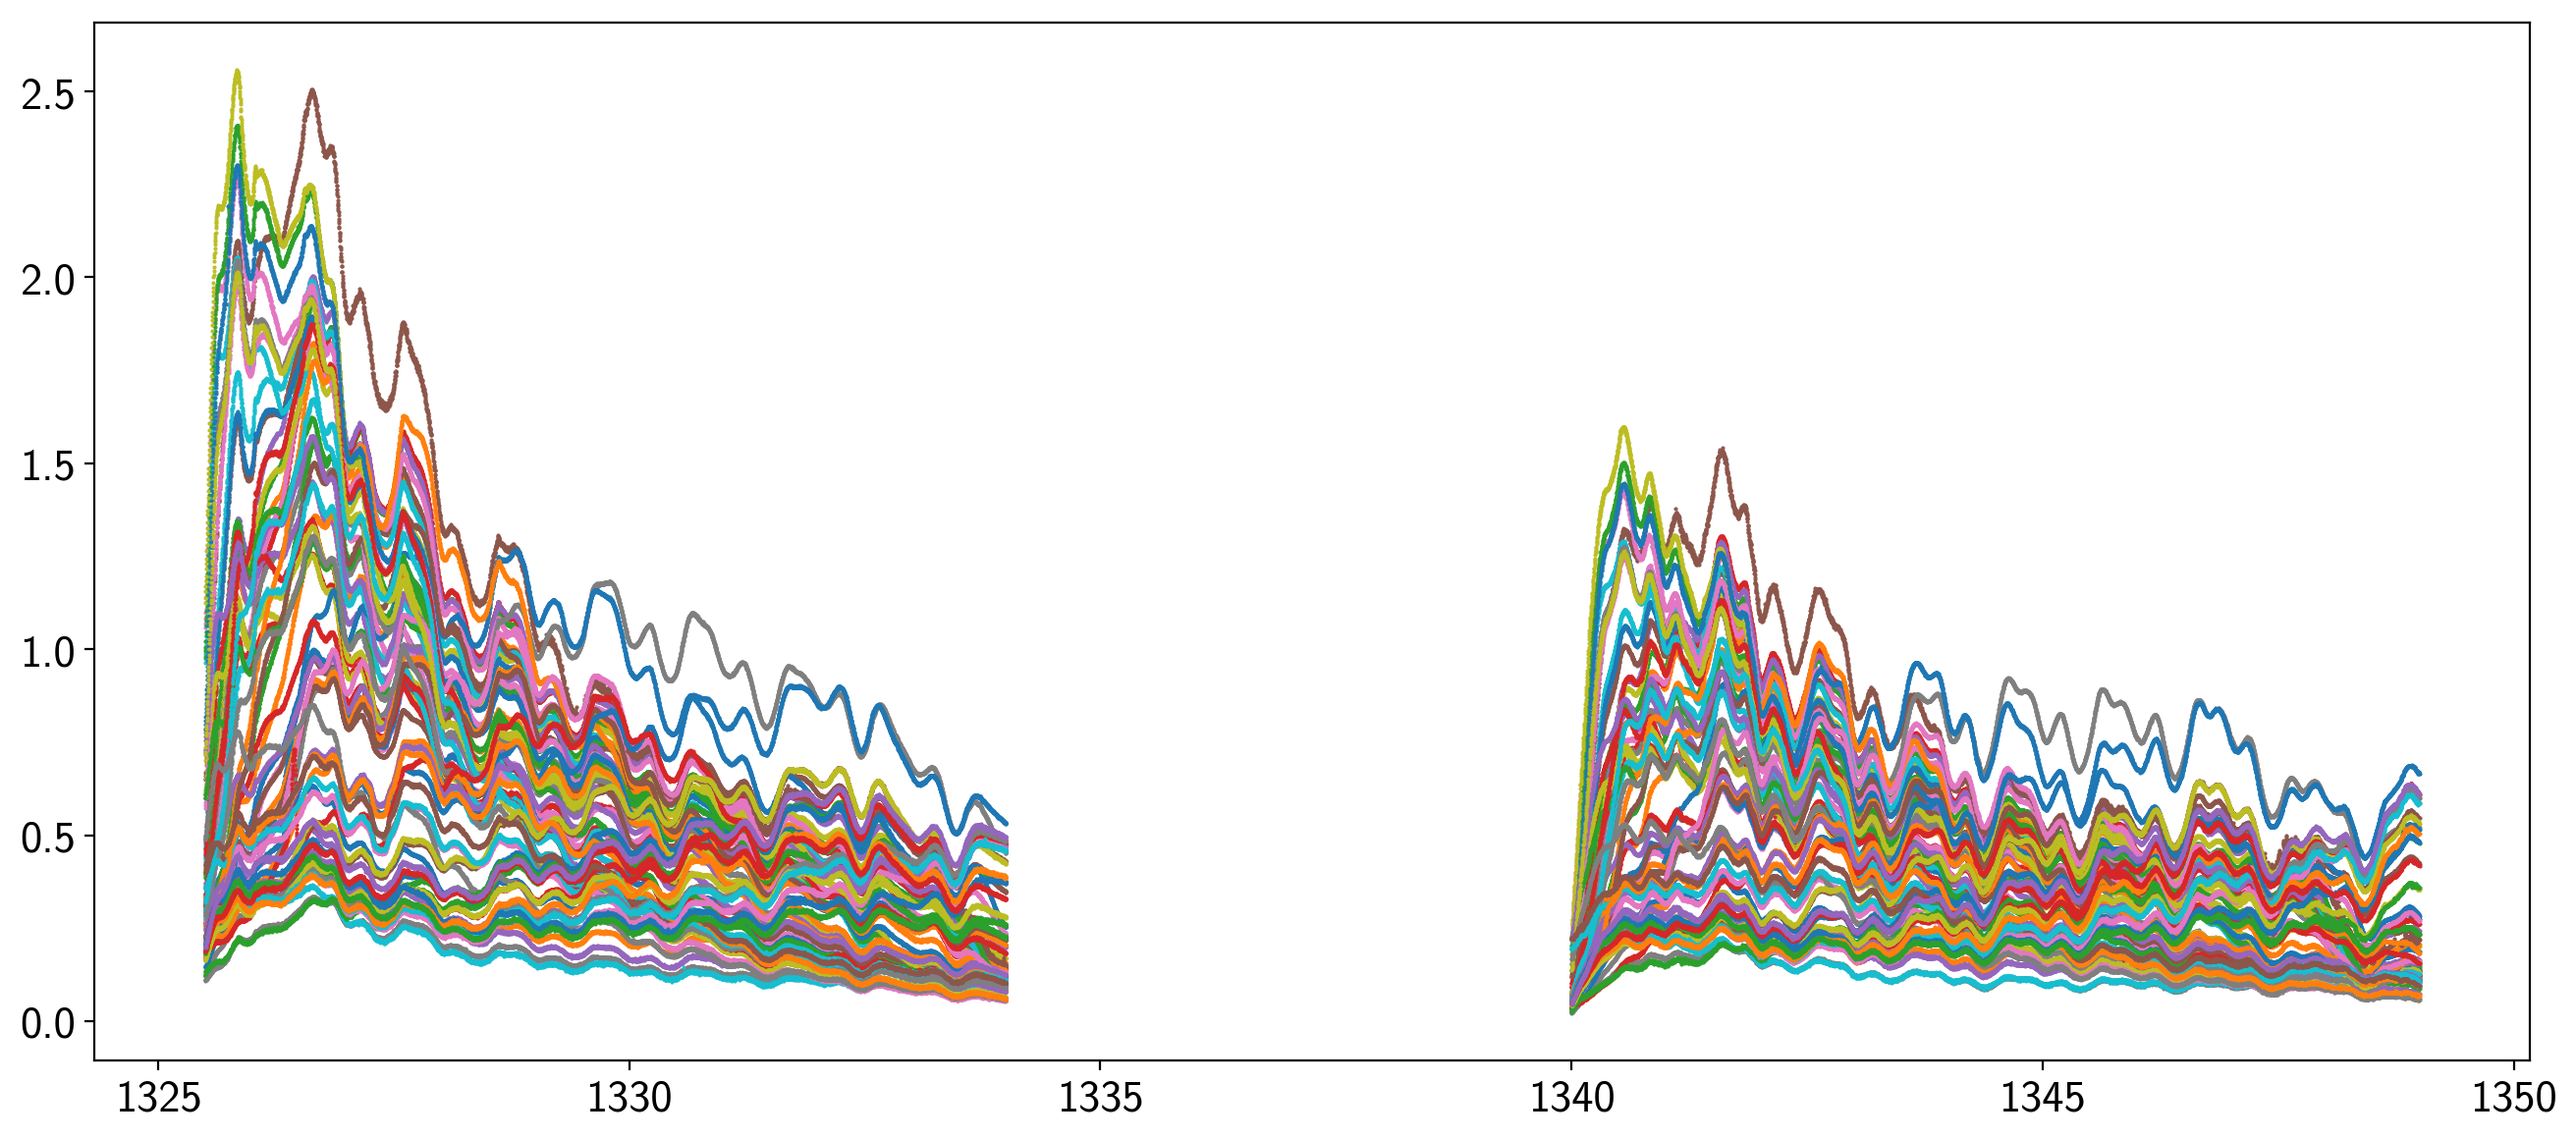

In [6]:
# Load the data for sector 1
data1 = np.load("../data/sector01-data.npz")
time1 = data1["time"]
flux1 = data1["flux"]
flux_err1 = data1["flux_err"]
bkg1 = data1["bkg"]
print("Loaded %d light curves from Sector 1." % len(flux1))

# Remove the background so we can do PLD
for i in range(len(flux1)):
    flux1[i] -= bkg1[i]

# Plot it
fig, ax = plt.subplots(1, figsize=(16, 7))
for f in flux1:
    line, = ax.plot(time1, f, '.', ms=1)

In [7]:
# Run Sector 2 data
if not os.path.exists("../data/sector02-data.npz"):
    %run ./Sector2.ipynb

Loaded 20 light curves from Sector 2.


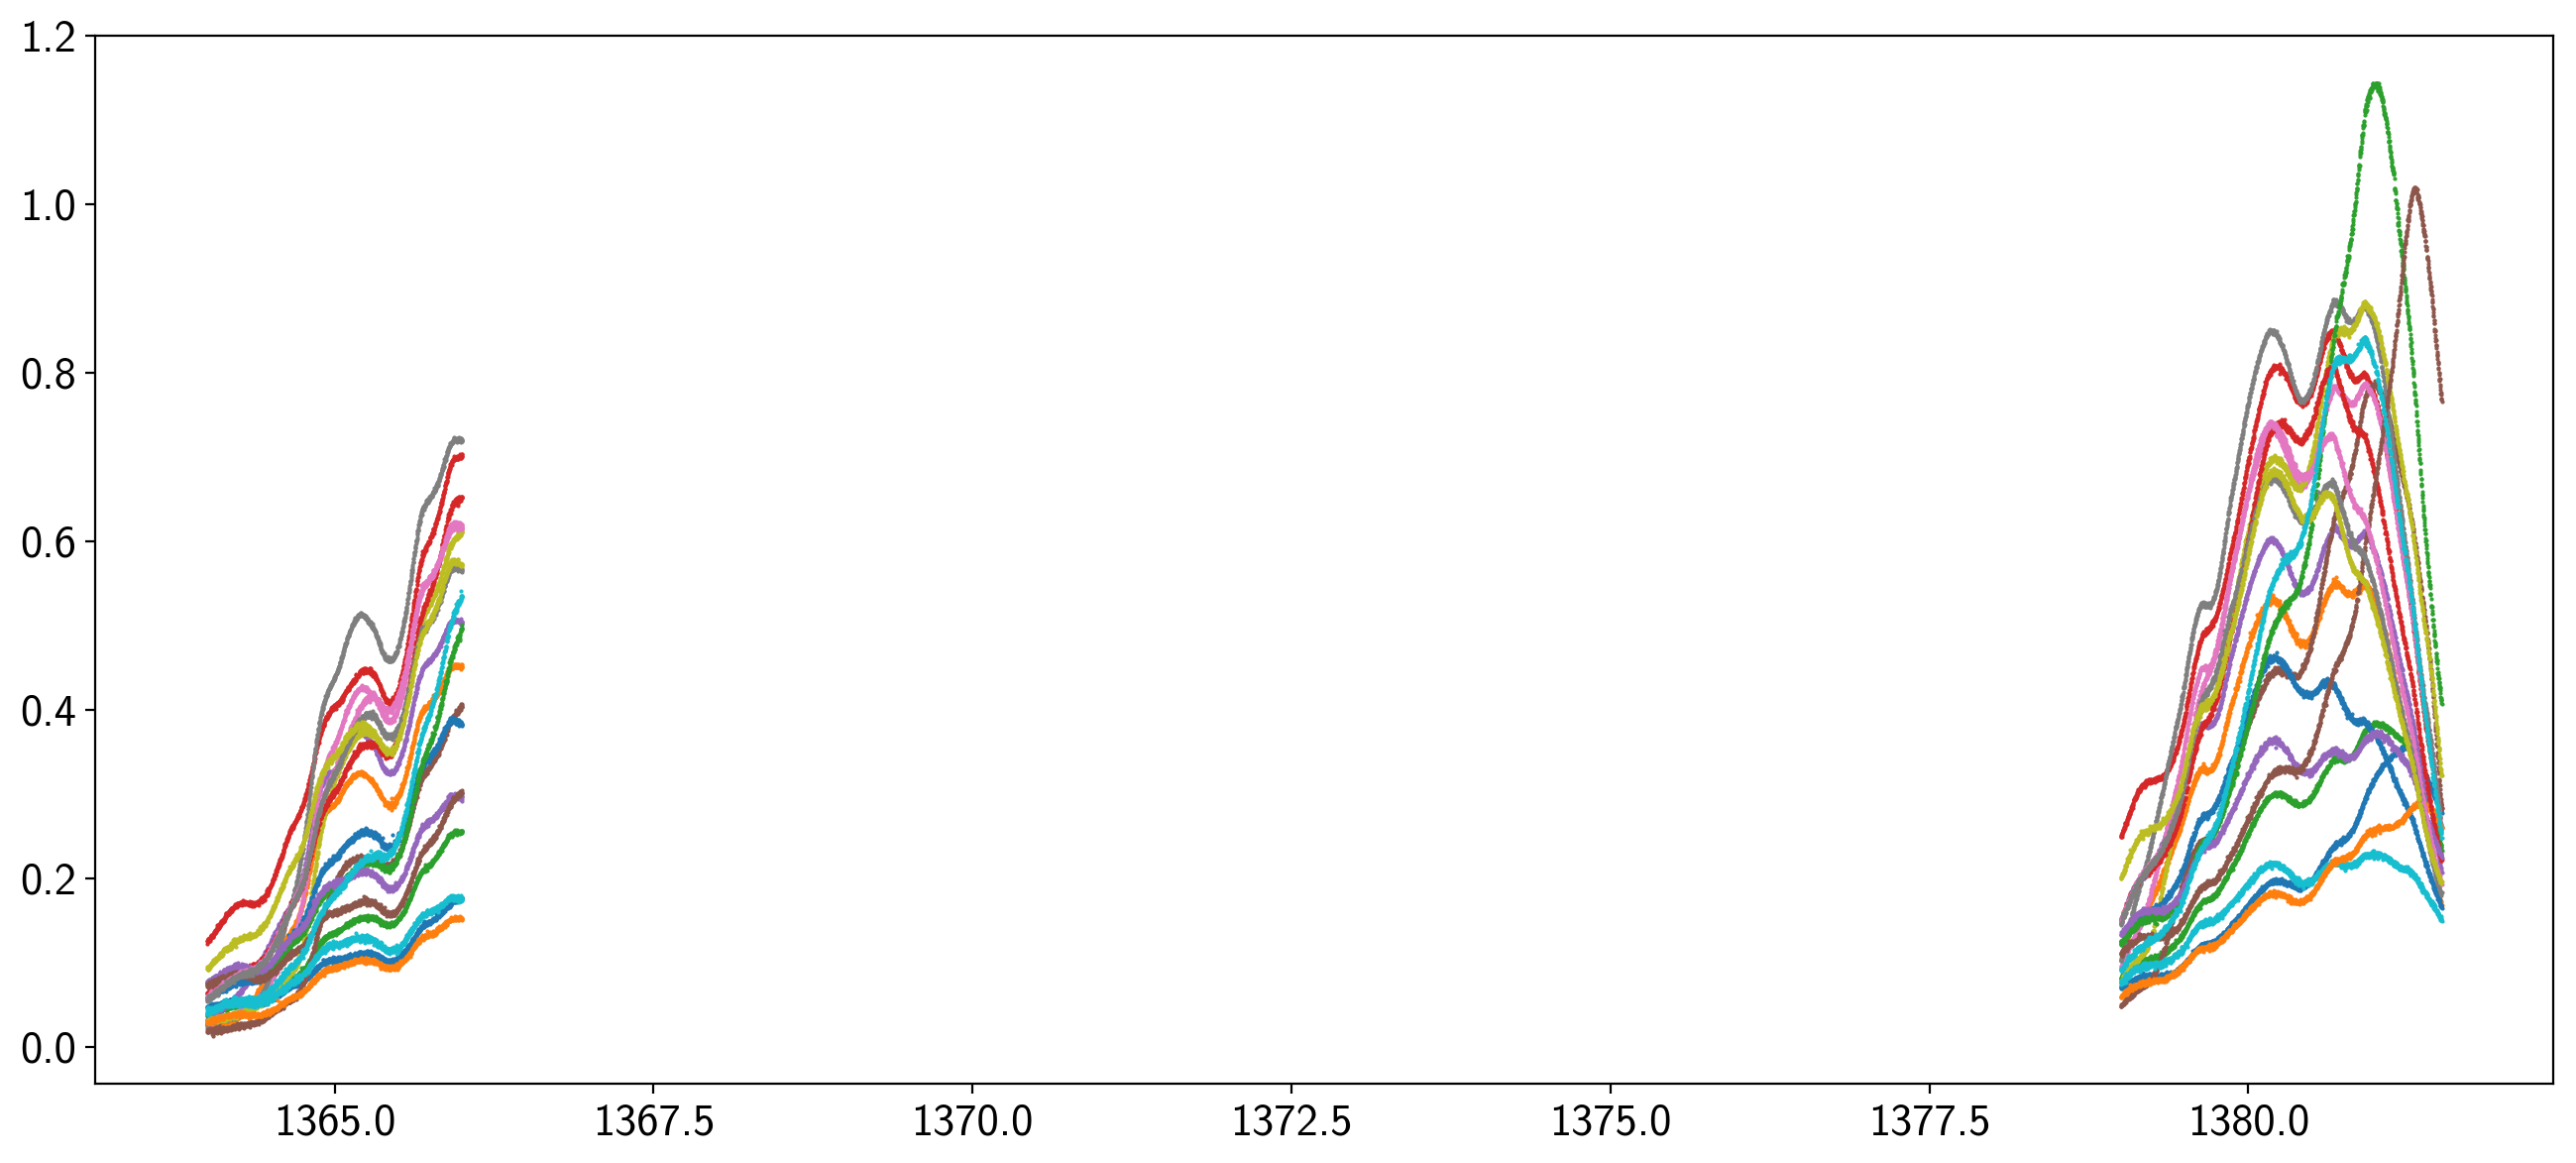

In [8]:
# Load the data for sector 2
data2 = np.load("../data/sector02-data.npz")
time2 = data2["time"]
flux2 = data2["flux"]
flux_err2 = data2["flux_err"]
bkg2 = data2["bkg"]
print("Loaded %d light curves from Sector 2." % len(flux2))

# Remove the background so we can do PLD
for i in range(len(flux2)):
    flux2[i] -= bkg2[i]

# Plot it
fig, ax = plt.subplots(1, figsize=(16, 7))
for f in flux2:
    line, = ax.plot(time2, f, '.', ms=1)

In [9]:
# Compute the polynomial basis for sector 1
nB1poly = 5
t11 = time1[time1 < 1337.5]
t12 = time1[time1 > 1337.5]
tt = 2 * ((t11 - t11[0]) / (t11[-1] - t11[0]) - 0.5)
B1 = np.vander(tt, N=nB1poly, increasing=True)
U, _, _ = svd(B1)
B11 = U[:, :nB1poly - 1]
B11 -= np.nanmedian(B11, axis=0).reshape(1, -1)
B11 = np.hstack((np.ones((len(tt), 1)), B11))
tt = 2 * ((t12 - t12[0]) / (t12[-1] - t12[0]) - 0.5)
B1 = np.vander(tt, N=nB1poly, increasing=True)
U, _, _ = svd(B1)
B12 = U[:, :nB1poly - 1]
B12 -= np.nanmedian(B12, axis=0).reshape(1, -1)
B12 = np.hstack((np.ones((len(tt), 1)), B12))
B1 = block_diag(B11, B12)

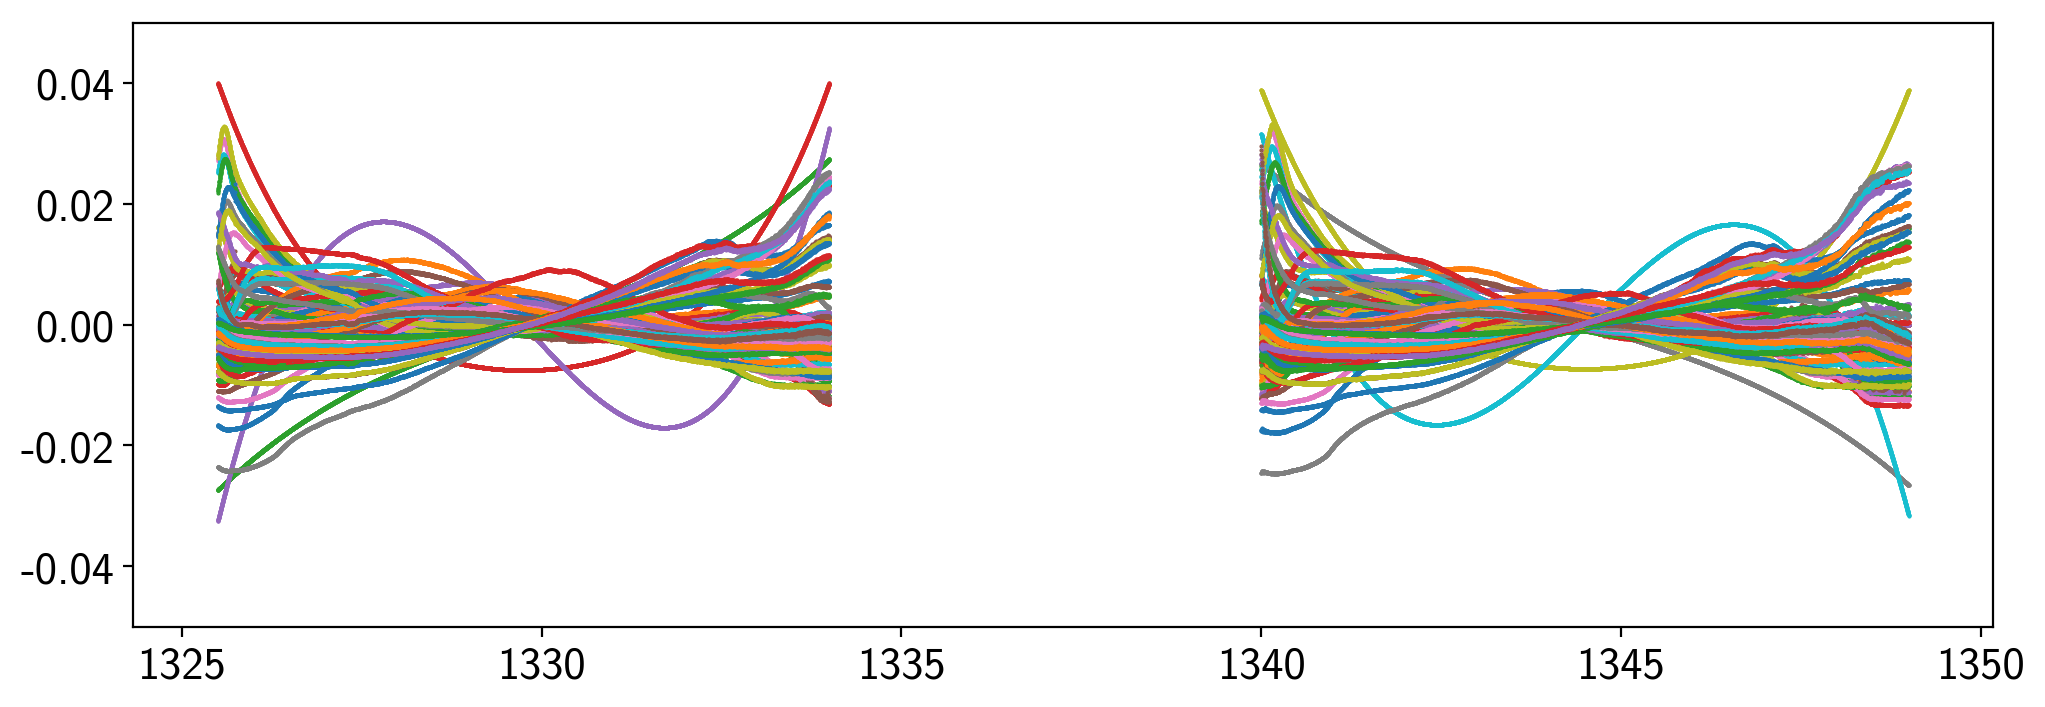

In [10]:
# Compute the PLD basis for sector 1
flux_sum1 = np.sum(flux1, axis=0)
B1PLD = np.hstack([(flux1[n] / flux_sum1).reshape(-1, 1) for n in range(len(flux1))])
B1PLD -= np.nanmedian(B1PLD, axis=0).reshape(1, -1)
B1 = np.hstack((B1, B1PLD))
for n in range(B1.shape[1]):
    plt.plot(time1, B1[:, n], '.', ms=1)
plt.ylim(-0.05, 0.05);

In [11]:
# Compute the polynomial basis for sector 2
nB2poly = 5
t21 = time2[time2 < 1372.5]
t22 = time2[time2 > 1372.5]
tt = 2 * ((t21 - t21[0]) / (t21[-1] - t21[0]) - 0.5)
B2 = np.vander(tt, N=nB2poly, increasing=True)
U, _, _ = svd(B2)
B21 = U[:, :nB2poly - 1]
B21 -= np.nanmedian(B21, axis=0).reshape(1, -1)
B21 = np.hstack((np.ones((len(tt), 1)), B21))
tt = 2 * ((t22 - t22[0]) / (t22[-1] - t22[0]) - 0.5)
B2 = np.vander(tt, N=nB2poly, increasing=True)
U, _, _ = svd(B2)
B22 = U[:, :nB2poly - 1]
B22 -= np.nanmedian(B22, axis=0).reshape(1, -1)
B22 = np.hstack((np.ones((len(tt), 1)), B22))
B2 = block_diag(B21, B22)

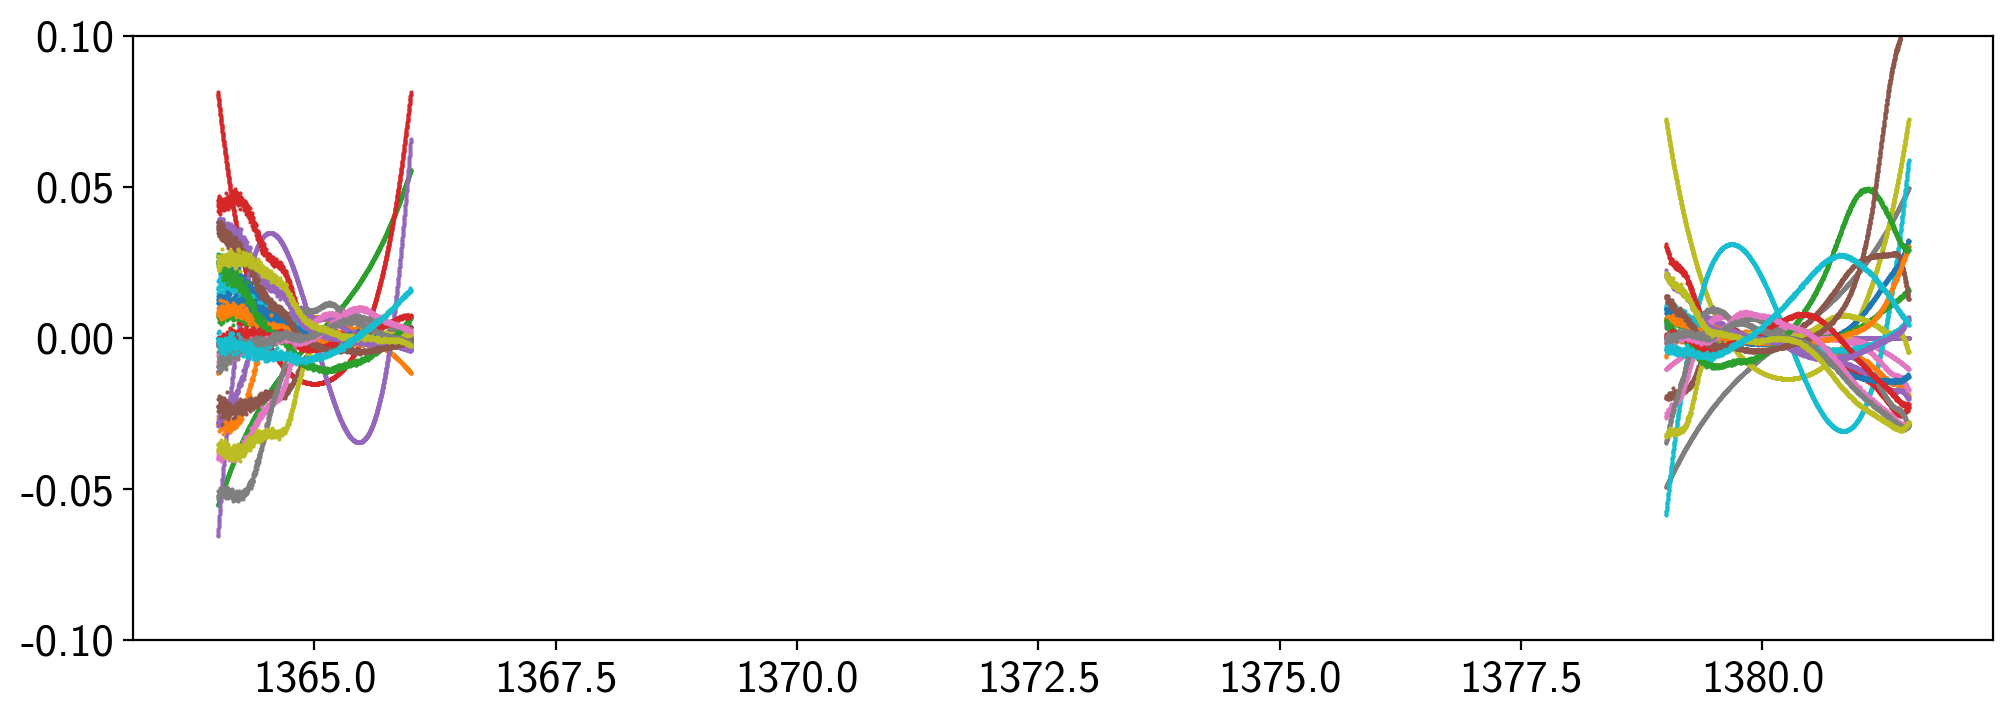

In [12]:
# Compute the PLD basis for sector 2
flux_sum2 = np.sum(flux2, axis=0)
B2PLD = np.hstack([(flux2[n] / flux_sum2).reshape(-1, 1) for n in range(len(flux2))])
B2PLD -= np.nanmedian(B2PLD, axis=0).reshape(1, -1)
B2 = np.hstack((B2, B2PLD))
for n in range(B2.shape[1]):
    plt.plot(time2, B2[:, n], '.', ms=1)
plt.ylim(-0.1, 0.1);

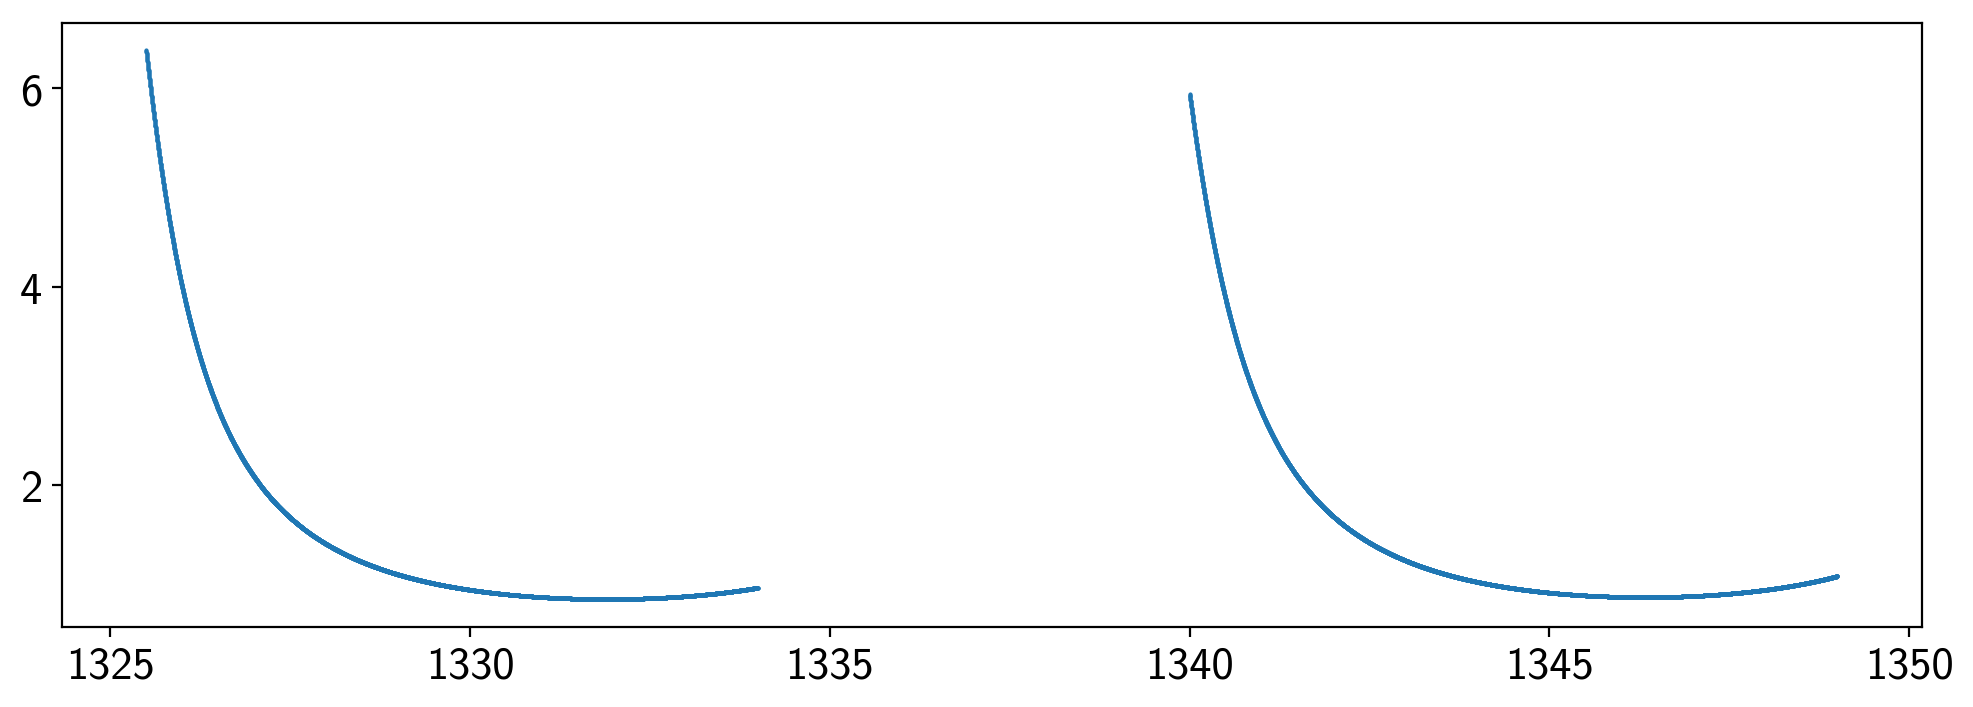

In [13]:
# Compute the TESS-Earth distance as a function of time for S1
tvec1 = earthshine.tess_earth_vector(time1)
tr1 = np.sqrt(tvec1[0] ** 2 + tvec1[1] ** 2 + tvec1[2] ** 2)

# This is the amplitude of the Earthshine (not a fit parameter)
amp1 = (1 / tr1 ** 2).reshape(-1, 1)
amp1 /= np.nanmedian(amp1)
amp1 = amp1.reshape(-1)
plt.plot(time1, amp1, '.', ms=1);

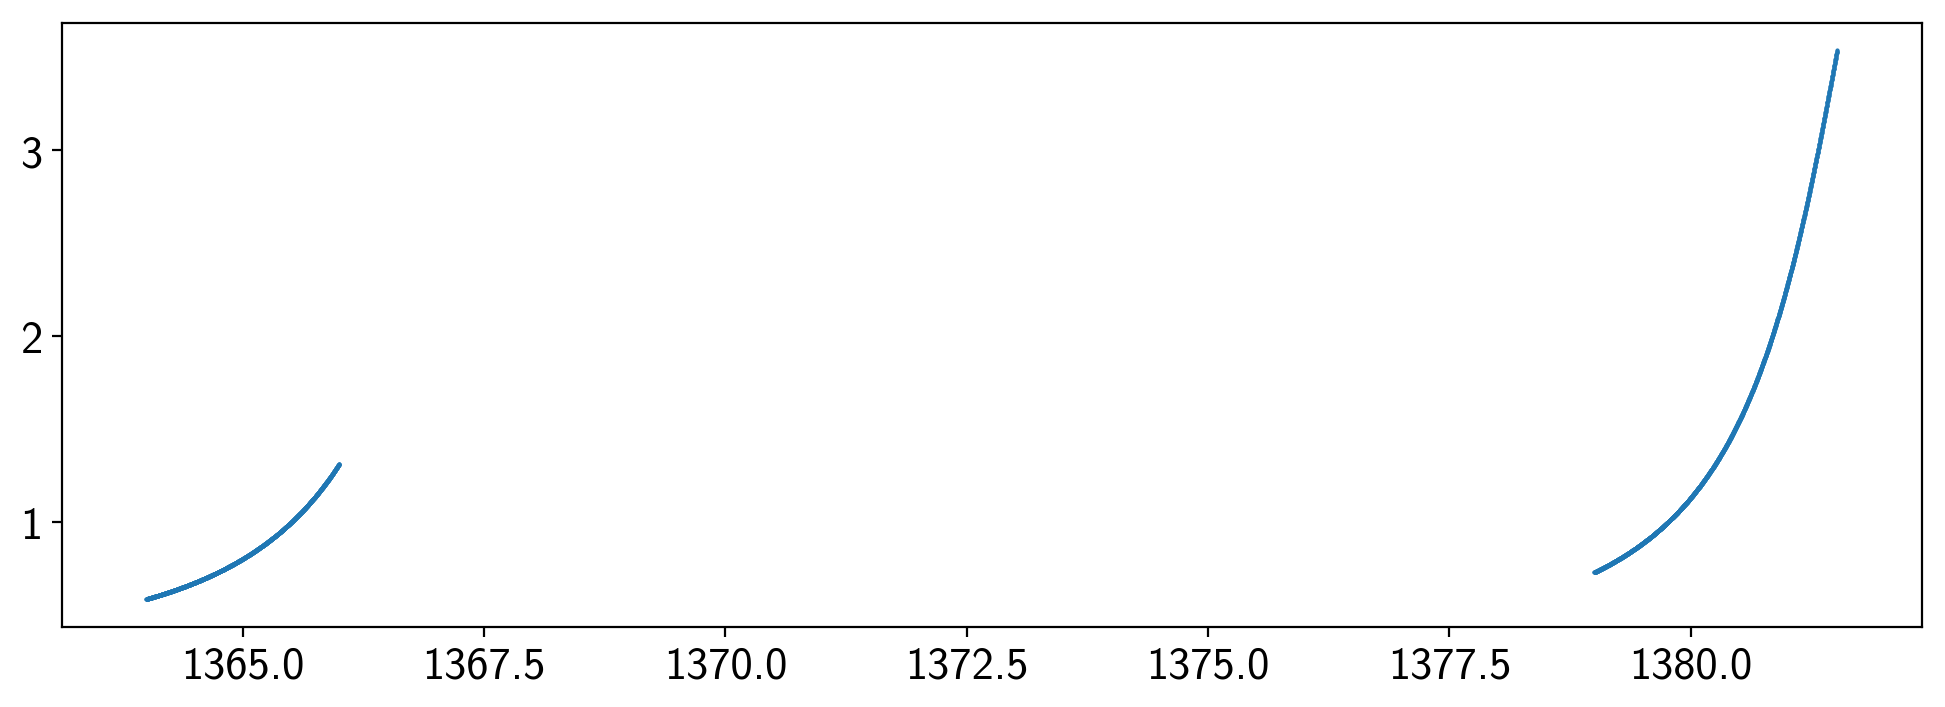

In [14]:
# Compute the TESS-Earth distance as a function of time for S2
tvec2 = earthshine.tess_earth_vector(time2)
tr2 = np.sqrt(tvec2[0] ** 2 + tvec2[1] ** 2 + tvec2[2] ** 2)

# This is the amplitude of the Earthshine (not a fit parameter)
amp2 = (1 / tr2 ** 2).reshape(-1, 1)
amp2 /= np.nanmedian(amp2)
amp2 = amp2.reshape(-1)
plt.plot(time2, amp2, '.', ms=1);

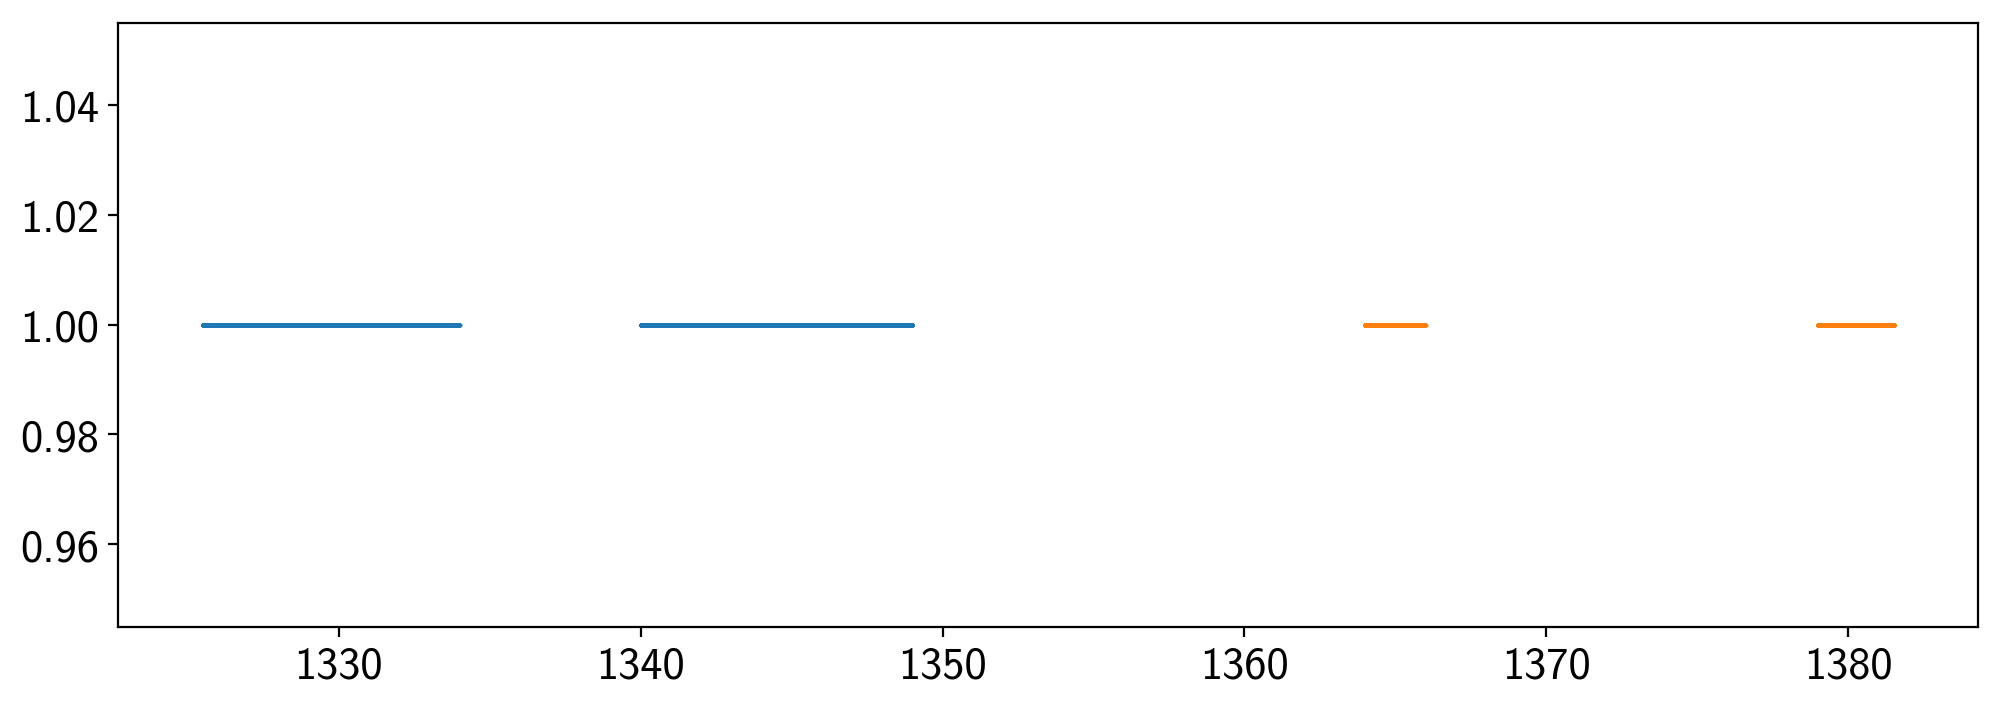

In [15]:
# Construct an orthogonal temporal basis
# (Just a constant in this case, since we're not modeling temporal variability)
nt = 1
t = 2 * ((np.append(time1, time2) - time1[0]) / (time2[-1] - time1[0]) - 0.5)
C = np.vander(t, N=nt, increasing=True)
U, _, _ = svd(C)
C = np.hstack((np.ones((len(t), 1)), U[:, :nt - 1]))
C1 = C[:len(time1)]
C2 = C[len(time1):]
plt.plot(time1, C1, '.', ms=1);
plt.plot(time2, C2, '.', ms=1);

  0%|          | 0/11363 [00:00<?, ?it/s]Compiling `get_inc_obl`... Done.
/Users/rluger/src/starry-dev/starry/Map/Map.py:321: UserWarning: Invalid keyword `t` in call to `X()`. Ignoring.
  warn(message)
Compiling `X`... Done.
  0%|          | 1/11363 [00:02<7:44:38,  2.45s/it]/Users/rluger/src/starry-dev/starry/Map/Map.py:321: UserWarning: Invalid keyword `t` in call to `X()`. Ignoring.
  warn(message)
100%|██████████| 11363/11363 [00:08<00:00, 1354.19it/s]


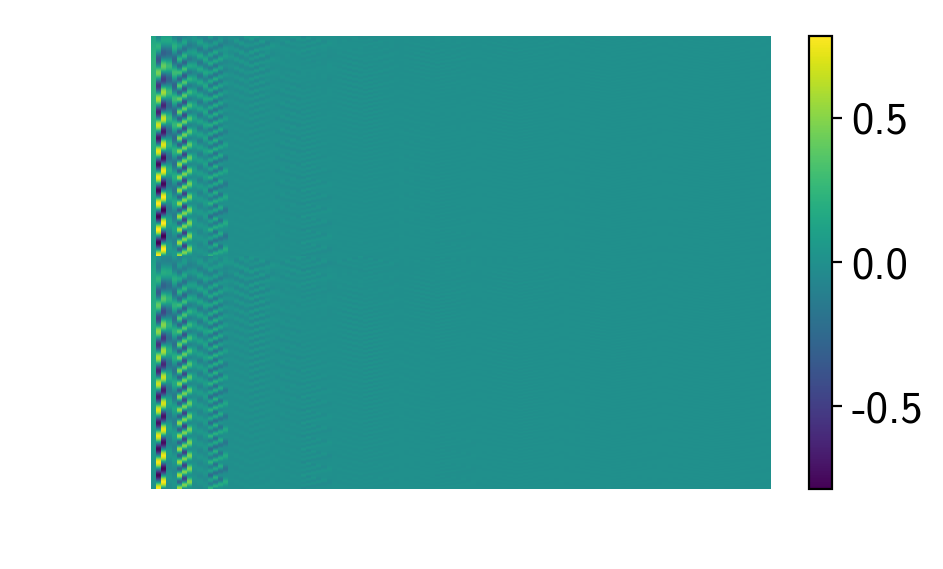

In [16]:
# The starry model for S1
ydeg = 10
map = starry.Map(ydeg=ydeg, lazy=False)
ny = (ydeg + 1) ** 2 - 1

# Get the design matrix
X1, X01 = earthshine.design_matrix(time1, ydeg=ydeg, nt=1, fit_linear_term=False)
X1 = np.hstack(([X1 * C1[:, k].reshape(-1, 1) for k in range(nt)]))

# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(X1, aspect="auto")
plt.colorbar(im)
ax.axis('off');

  0%|          | 0/3019 [00:00<?, ?it/s]Compiling `get_inc_obl`... Done.
Compiling `X`... Done.
100%|██████████| 3019/3019 [00:01<00:00, 1768.40it/s]


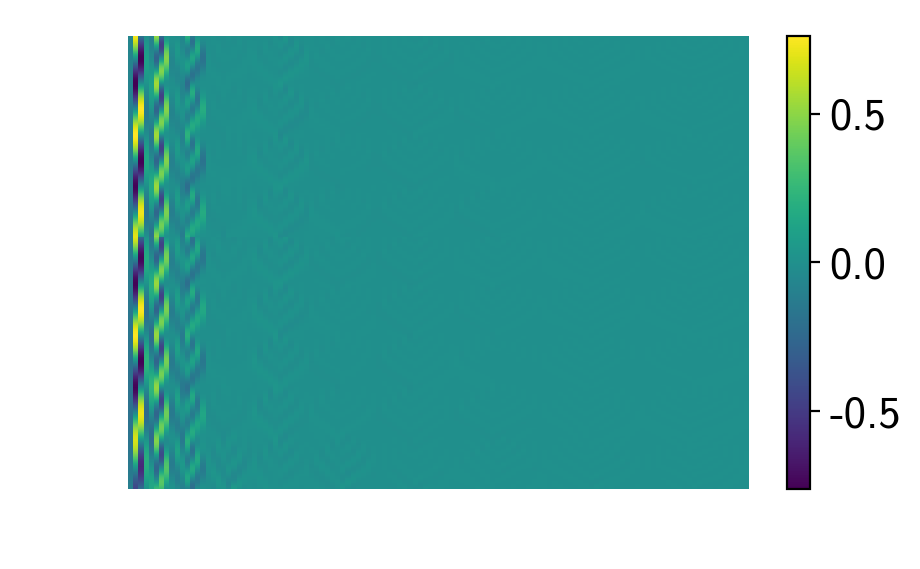

In [17]:
# The starry model for S2
X2, X02 = earthshine.design_matrix(time2, ydeg=ydeg, nt=1, fit_linear_term=False)
X2 = np.hstack(([X2 * C2[:, k].reshape(-1, 1) for k in range(nt)]))

# Plot it
fig, ax = plt.subplots(1, figsize=(5, 3))
im = ax.imshow(X2, aspect="auto")
plt.colorbar(im)
ax.axis('off');

In [18]:
# The pixelization matrix (def. overkill!)
npix = 50000
res = int(np.sqrt(npix))
ntsamp = nt
omega = np.linspace(0, 2 * np.pi, res)
z = np.linspace(0.01, 1 - 0.01, res)
omega, z = np.meshgrid(omega, z)
omega = omega.flatten()
z = z.flatten()
npix = len(z) * 2
x = np.sqrt(1 - z ** 2) * np.cos(omega)
y = np.sqrt(1 - z ** 2) * np.sin(omega)
x = np.append(x, x)
y = np.append(y, y)
z = np.append(z, -z)
P = map.P(x=x, y=y, z=z)
P0 = P[:, 0].reshape(-1)
P = P[:, 1:].reshape(-1, ny)

Compiling `P`... Done.


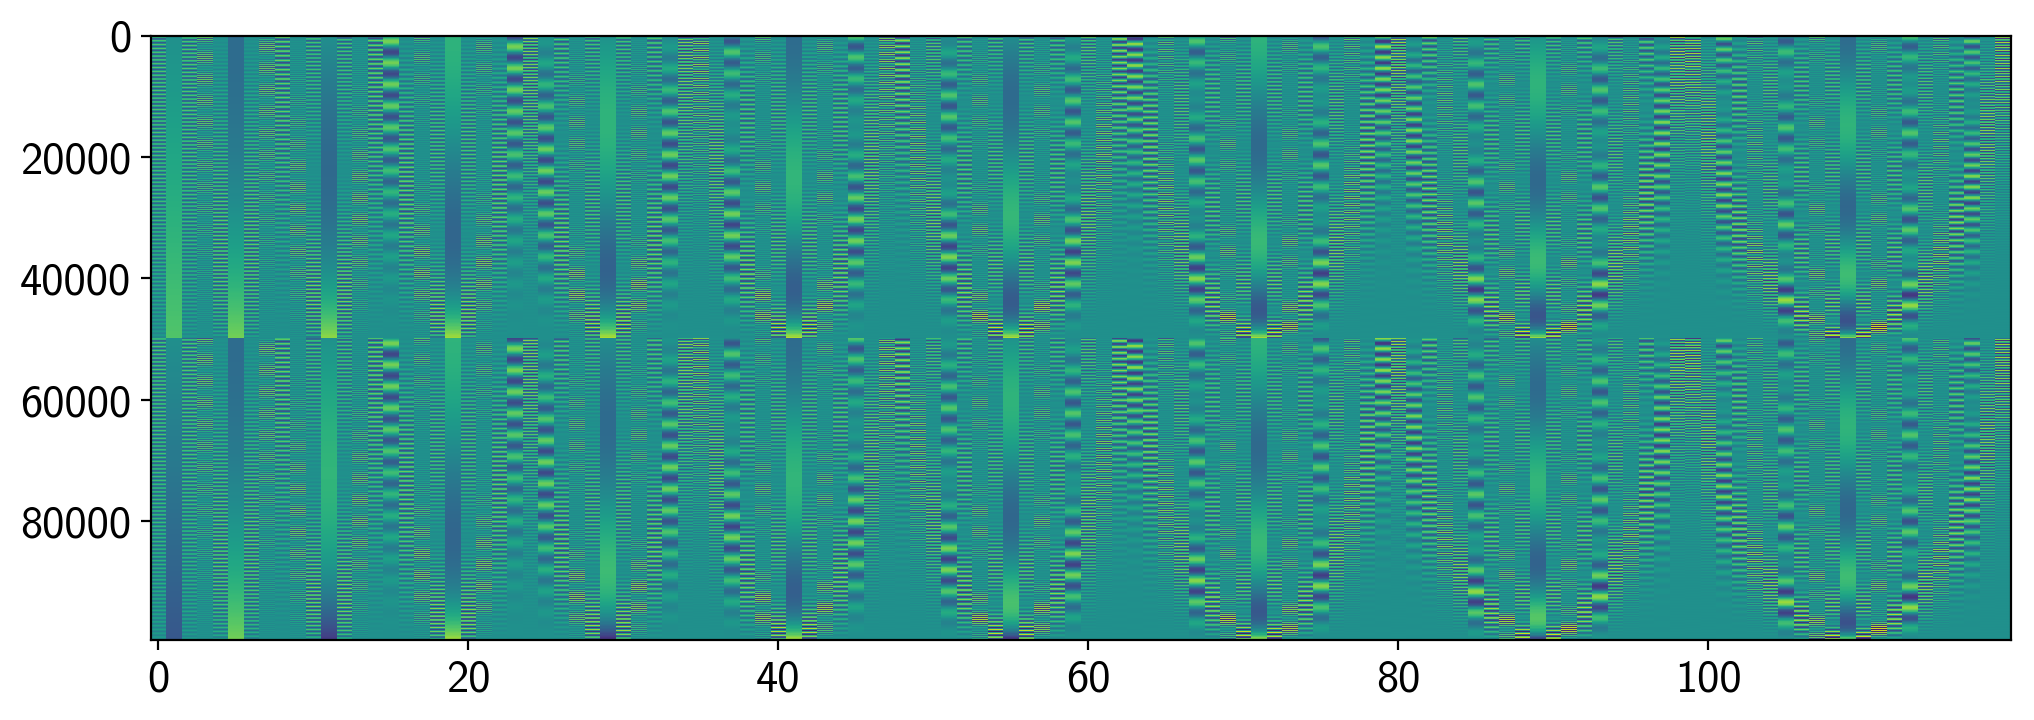

In [19]:
# Samples across time (just one for our static map)
tsamp = np.linspace(0, len(time1) + len(time2) - 1, ntsamp, dtype=int)
P = np.vstack([np.hstack([P * C[j, k] for k in range(nt)]) for j in tsamp])
P0 = np.concatenate([P0 for j in tsamp])
plt.imshow(P, aspect="auto");

In [20]:
# Define the priors
def amp_l(l, a=2.0, b=1.5, c=0.035):
    """The power spectrum prior."""
    if l == 0:
        return 1.0
    elif l < a:
        return c * l ** b
    else:
        return c * a ** (2 * b) * l ** -b

def amp_t(t):
    """The prior on the temporal components."""
    if t == 0:
        return 1
    else:
        return 0.1 * np.exp(-(t - 1))    
    
# The L2 prior on the Ylms
LX = np.ones(ny * nt)
i = 0
for n in range(nt):
    for l in range(1, ydeg + 1):
        for m in range(-l, l + 1):
            LX[i] = amp_l(l) ** 2 * amp_t(n) ** 2
            i += 1
power_spectrum = np.array([amp_l(l) for l in range(1, ydeg + 1)])

# Downweight the prior by this amount
# when computing the linear solution
linLXfac = (0.0005) ** 2
            
# Define the L2 prior on the multiplicative model
LB1 = (0.05) ** 2
LB2 = (0.05) ** 2

# The (inverse) penalty factor for intensity outside of [0, 1]
LP = (1e-4) ** 2

In [21]:
# Initialize the models for S1
nc1 = len(time1)
nl1 = len(flux1)

Xwx1 = np.ones(nc1)
Bwb1 = np.array([np.ones(nc1) * amp1 for i in range(nl1)]).reshape(-1)

# The diagonal of the data covariance
D1 = flux_err1.reshape(-1) ** 2

# The flattened light curves
data1 = flux1.reshape(-1)

In [22]:
# Initialize the models for S2
nc2 = len(time2)
nl2 = len(flux2)

Xwx2 = np.ones(nc2)
Bwb2 = np.array([np.ones(nc2) * amp2 for i in range(nl2)]).reshape(-1)

# The diagonal of the data covariance
D2 = flux_err2.reshape(-1) ** 2

# The flattened light curves
data2 = flux2.reshape(-1)

In [23]:
# The augmented starry design matrix & dataset
XBig1 = np.tile(X1, (nl1, 1))
X0Big1 = np.tile(X01, (nl1, 1)).reshape(-1)
XBig2 = np.tile(X2, (nl2, 1))
X0Big2 = np.tile(X02, (nl2, 1)).reshape(-1)
XBig = np.vstack((XBig1, XBig2))
X0Big = np.append(X0Big1, X0Big2)

D = np.append(D1, D2)
data = np.append(data1, data2)

In [24]:
# Solve the bilinear problem iteratively. Here our loss function is *just* the L2
# norm, so we downweight the power spectrum prior on the coefficients to keep
# the map positive and well-behaved. This will serve as an initial guess for the
# TensorFlow optimization below.
compute = False

if compute or not os.path.exists("../data/bilinear_S1_S2.npz"):
    niter = 50
    loss = np.zeros(niter)
    like = np.zeros(niter)
    wb1 = np.zeros((nl1, B1.shape[1]))
    wb2 = np.zeros((nl2, B2.shape[1]))
    for n in tqdm(range(niter)):
        # Compute the baseline model for S1: one per light curve
        for i in range(nl1):
            l = slice(i * nc1, (i + 1) * nc1, 1)
            wb1[i] = earthshine.MAP(B1, LB1, D1[l] / (Xwx1 * amp1) ** 2, data1[l] / (Xwx1 * amp1))
            Bwb1[l] = np.dot(B1, wb1[i]) * amp1
            
        # Compute the baseline model for S2: one per light curve
        for i in range(nl2):
            l = slice(i * nc2, (i + 1) * nc2, 1)
            wb2[i] = earthshine.MAP(B2, LB2, D2[l] / (Xwx2 * amp2) ** 2, data2[l] / (Xwx2 * amp2))
            Bwb2[l] = np.dot(B2, wb2[i]) * amp2

        # Compute the starry model: shared by all light curves
        Bwb = np.append(Bwb1, Bwb2)
        wx = earthshine.MAP(XBig, linLXfac * LX, D / Bwb ** 2, data / Bwb - X0Big)
        Xwx1 = np.dot(X1, wx) + X01
        Xwx2 = np.dot(X2, wx) + X02

        # Render the image (for the loss calculation)
        img = np.dot(P, wx) + P0

        # Compute the loss: chi squared
        model1 = Bwb1 * np.tile(Xwx1, nl1)
        model2 = Bwb2 * np.tile(Xwx2, nl2)
        model = np.append(model1, model2)
        like[n] = 0.5 * np.sum(((data - model) ** 2 / D))
        loss[n] = like[n] + 0.5 * (
            np.sum([wb1[i] ** 2 / LB1 for i in range(nl1)]) +
            np.sum([wb2[i] ** 2 / LB2 for i in range(nl2)]) +
            np.sum(wx ** 2 / LX) +
            np.sum(img[img < 0] ** 2 / LP) + 
            np.sum((img[img > 1] - 1) ** 2 / LP)
        )
    np.savez("../data/bilinear_S1_S2.npz", wb1=wb1, wb2=wb2, wx=wx, loss=loss, like=like)
else:
    bdata = np.load("../data/bilinear_S1_S2.npz")
    wb1 = bdata["wb1"]
    wb2 = bdata["wb2"]
    wx = bdata["wx"]
    loss = bdata["loss"]
    like = bdata["like"]

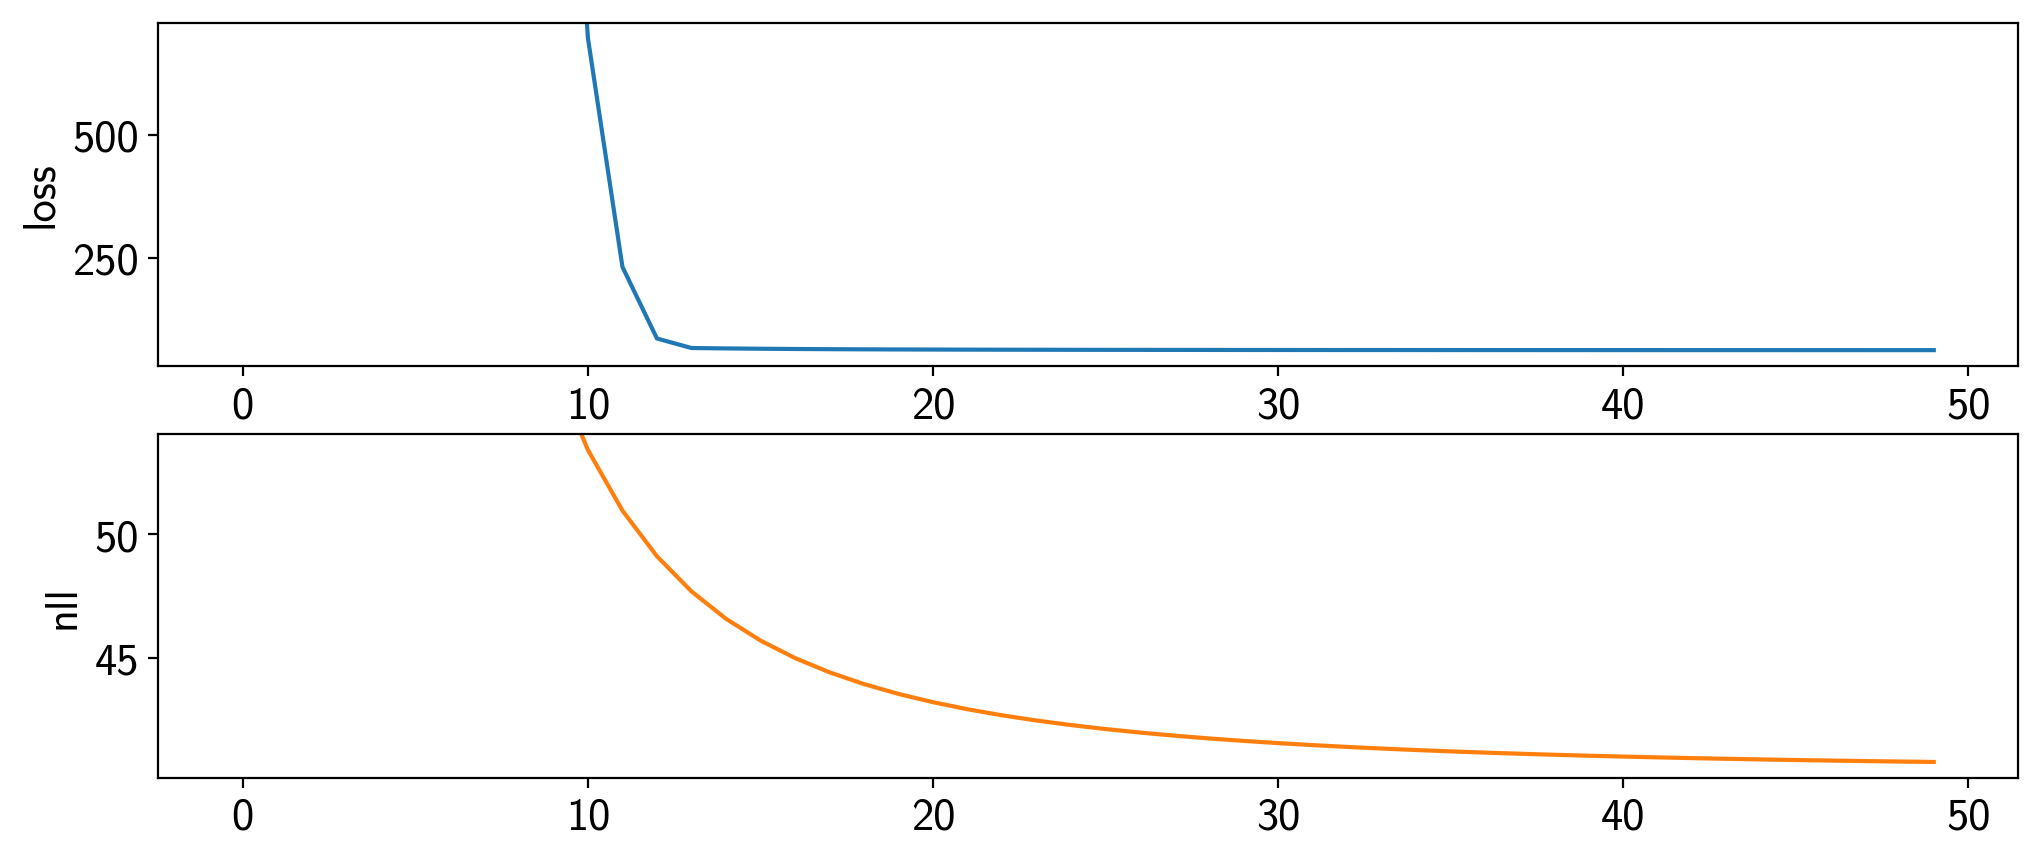

In [25]:
# Plot the loss and the negative log likelihood
fig, ax = plt.subplots(2, figsize=(12, 5))
burn = 10
ax[0].plot(loss[burn:] / (nc1 * nl1 + nc2 * nl2), alpha=0)
ax[1].plot(like[burn:] / (nc1 * nl1 + nc2 * nl2), alpha=0)
ax[0].set_ylim(*ax[0].get_ylim())
ax[1].set_ylim(*ax[1].get_ylim())
ax[0].plot(loss / (nc1 * nl1 + nc2 * nl2), color="C0");
ax[1].plot(like / (nc1 * nl1 + nc2 * nl2), color="C1");
ax[0].set_ylabel("loss")
ax[1].set_ylabel("nll");

Compiling `render`... Done.


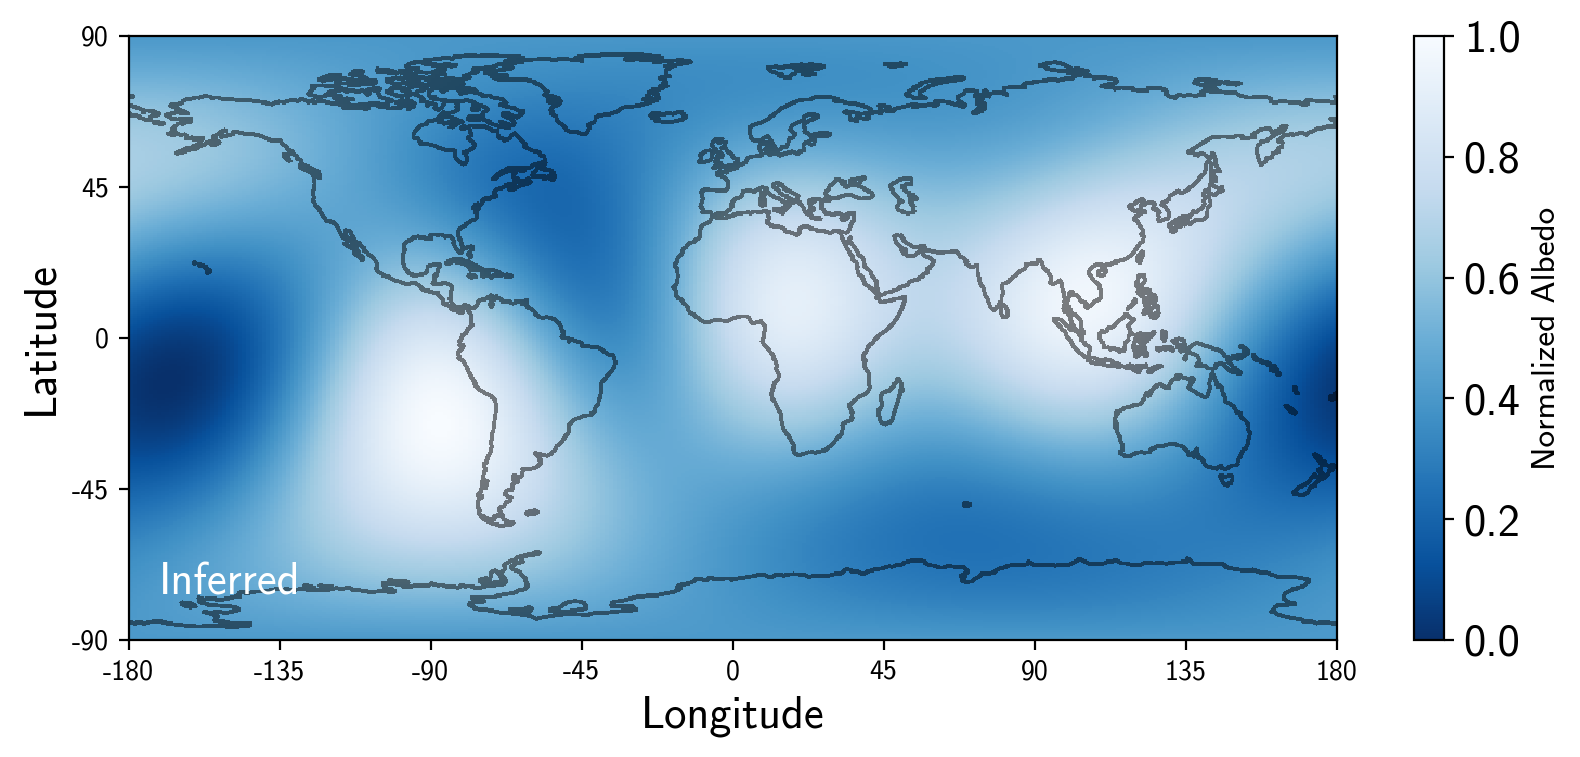

In [26]:
# Sneak peek at the map so far
# Remember it is *super* regularized, so
# the smoothing is extreme
map[1:, :] = wx
img = map.render(res=300, projection="rect")[0]
img = (img - np.nanmin(img)) / (np.nanmax(img) - np.nanmin(img))
fig, ax = plt.subplots(1, figsize=(10, 4))
im = ax.imshow(img, cmap=cmap, extent=(-180, 180, -90, 90), origin="lower", vmin=0, vmax=1);
cb = fig.colorbar(im, ax=ax);
cb.set_label(label='Normalized Albedo', fontsize=12)
ax.imshow(coastlines, extent=(-180, 180, -90, 90), alpha=0.5);
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_yticks([-90, -45, 0, 45, 90]);
ax.set_xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180]);
for tick in ax.xaxis.get_major_ticks() + ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
ax.annotate("Inferred", xy=(0.025, 0.075), xycoords="axes fraction", color="w", ha="left", fontsize=16);
fig.savefig("../tex/figures/map_L2.pdf", bbox_inches="tight", dpi=300)

In [27]:
# Declare the TensorFlow model
session = tf.Session()
T = tf.float64

# The data
tdata1 = tf.constant(data1.reshape(-1, 1), dtype=T)
tcov1 = tf.constant(D1.reshape(-1, 1), dtype=T)
tamp1 = tf.constant(np.tile(amp1, nl1).reshape(-1, 1), dtype=T)
tdata2 = tf.constant(data2.reshape(-1, 1), dtype=T)
tcov2 = tf.constant(D2.reshape(-1, 1), dtype=T)
tamp2 = tf.constant(np.tile(amp2, nl2).reshape(-1, 1), dtype=T)

# The constant matrices
tB1 = tf.constant(B1, dtype=T)
tX1 = tf.constant(X1, dtype=T)
tX01 = tf.constant(X01.reshape(-1, 1), dtype=T)
tB2 = tf.constant(B2, dtype=T)
tX2 = tf.constant(X2, dtype=T)
tX02 = tf.constant(X02.reshape(-1, 1), dtype=T)
tP = tf.constant(P, dtype=T)
tP0 = tf.constant(P0.reshape(-1, 1), dtype=T)

# The priors
tLB1 = tf.constant(LB1, dtype=T)
tLB2 = tf.constant(LB2, dtype=T)
tLP = tf.constant(LP, dtype=T)
tLogPowerVar = tf.constant(0.3 ** 2, dtype=T)
tgammamean = tf.constant(1.5, dtype=T)
tgammavar = tf.constant(0.1 ** 2, dtype=T)

# The things we're solving for
twb1 = tf.Variable(wb1.T, dtype=T)
twb2 = tf.Variable(wb2.T, dtype=T)
twx = tf.Variable(wx.reshape(-1, 1), dtype=T)
tgamma = tf.Variable(1.5, dtype=T)

# This is our actual model
tBwb1 = tf.reshape(tf.transpose(tf.matmul(tB1, twb1)), [-1, 1]) * tamp1
tXwx1 = tf.matmul(tX1, twx) + tX01
tmodel1 = tBwb1 * tf.tile(tXwx1, [nl1, 1])
tBwb2 = tf.reshape(tf.transpose(tf.matmul(tB2, twb2)), [-1, 1]) * tamp2
tXwx2 = tf.matmul(tX2, twx) + tX02
tmodel2 = tBwb2 * tf.tile(tXwx2, [nl2, 1])

# The chi^2 part of the loss function
tloss_like1 = 0.5 * tf.reduce_sum(tf.squared_difference(tdata1, tmodel1) / tcov1)
tloss_like2 = 0.5 * tf.reduce_sum(tf.squared_difference(tdata2, tmodel2) / tcov2)
tloss_like = tloss_like1 + tloss_like2

# The prior on the baseline model
tloss_mult1 = 0.5 * tf.reduce_sum(tf.square(twb1) / tLB1)
tloss_mult2 = 0.5 * tf.reduce_sum(tf.square(twb2) / tLB2)
tloss_mult = tloss_mult1 + tloss_mult2

# Enforce the power spectrum
tpower = tf.convert_to_tensor([tf.reduce_sum([tf.square(twx[l ** 2 + l + m - 1]) 
                                for m in range(-l, l + 1)], axis=0) 
                                for l in range(1, ydeg + 1)], dtype=T)
tLogPowerMean = tf.reshape(tf.log(tf.pow(tf.convert_to_tensor(np.arange(1, ydeg + 1), dtype=T), -tgamma)), (-1, 1))
tloss_spec = 0.5 * tf.reduce_sum(tf.squared_difference(tf.log(tpower)[4:], tLogPowerMean[4:]) / tLogPowerVar)
tloss_gamma = 0.5 * tf.squared_difference(tgamma, tgammamean) / tgammavar

# Render the map on a coarse theta-phi-time grid and 
# compute the penalty on intensities outside of [0, 1]
timg = tf.matmul(tP, twx) + tP0
tloss_neg = 0.5 * tf.reduce_sum(tf.square(tf.where(timg < 0, timg, tf.zeros_like(timg))) / tLP)
tloss_pos = 0.5 * tf.reduce_sum(tf.square(tf.where(timg > 1, timg - 1, tf.zeros_like(timg))) / tLP)

# The total loss function
tloss = tloss_like + tloss_mult + tloss_spec + tloss_gamma + tloss_neg + tloss_pos

# Set up the optimizer
var_list = [twb1, twb2, twx, tgamma]
opt = tf.train.AdamOptimizer().minimize(tloss, var_list=var_list)
session.run(tf.global_variables_initializer())

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


In [28]:
# Iterate: we are now solving the full problem, with the full loss function
# specified by all our crazy constraints
tniter = 850
like = np.zeros(tniter)
loss = np.zeros(tniter)
with tqdm(total=tniter, postfix=[0, 0]) as tq:
    for i in range(tniter):
        session.run(opt)
        like[i] = session.run(tloss_like)
        loss[i] = session.run(tloss)
        tq.postfix[0] = int(loss[i] / (nc1 * nl1 + nc2 * nl2))
        tq.postfix[1] = int(like[i] / (nc1 * nl1 + nc2 * nl2))
        tq.update()

100%|██████████| 850/850 [00:55<00:00, 19.60it/s[39, 21]]


In [29]:
# Get the values of a bunch of the TF variables
wb1 = session.run(tf.squeeze(twb1)).T
wb2 = session.run(tf.squeeze(twb2)).T
wx = session.run(tf.squeeze(twx))
Bwb1 = session.run(tf.squeeze(tBwb1))
Xwx1 = session.run(tf.squeeze(tXwx1))
model1 = session.run(tf.squeeze(tmodel1))
Bwb2 = session.run(tf.squeeze(tBwb2))
Xwx2 = session.run(tf.squeeze(tXwx2))
model2 = session.run(tf.squeeze(tmodel2))
power = session.run(tpower)
img = session.run(tf.squeeze(timg))

In [30]:
gamma = session.run(tgamma)
print("Inferred power spectrum power law index: %.5f" % gamma)

Inferred power spectrum power law index: 1.57653


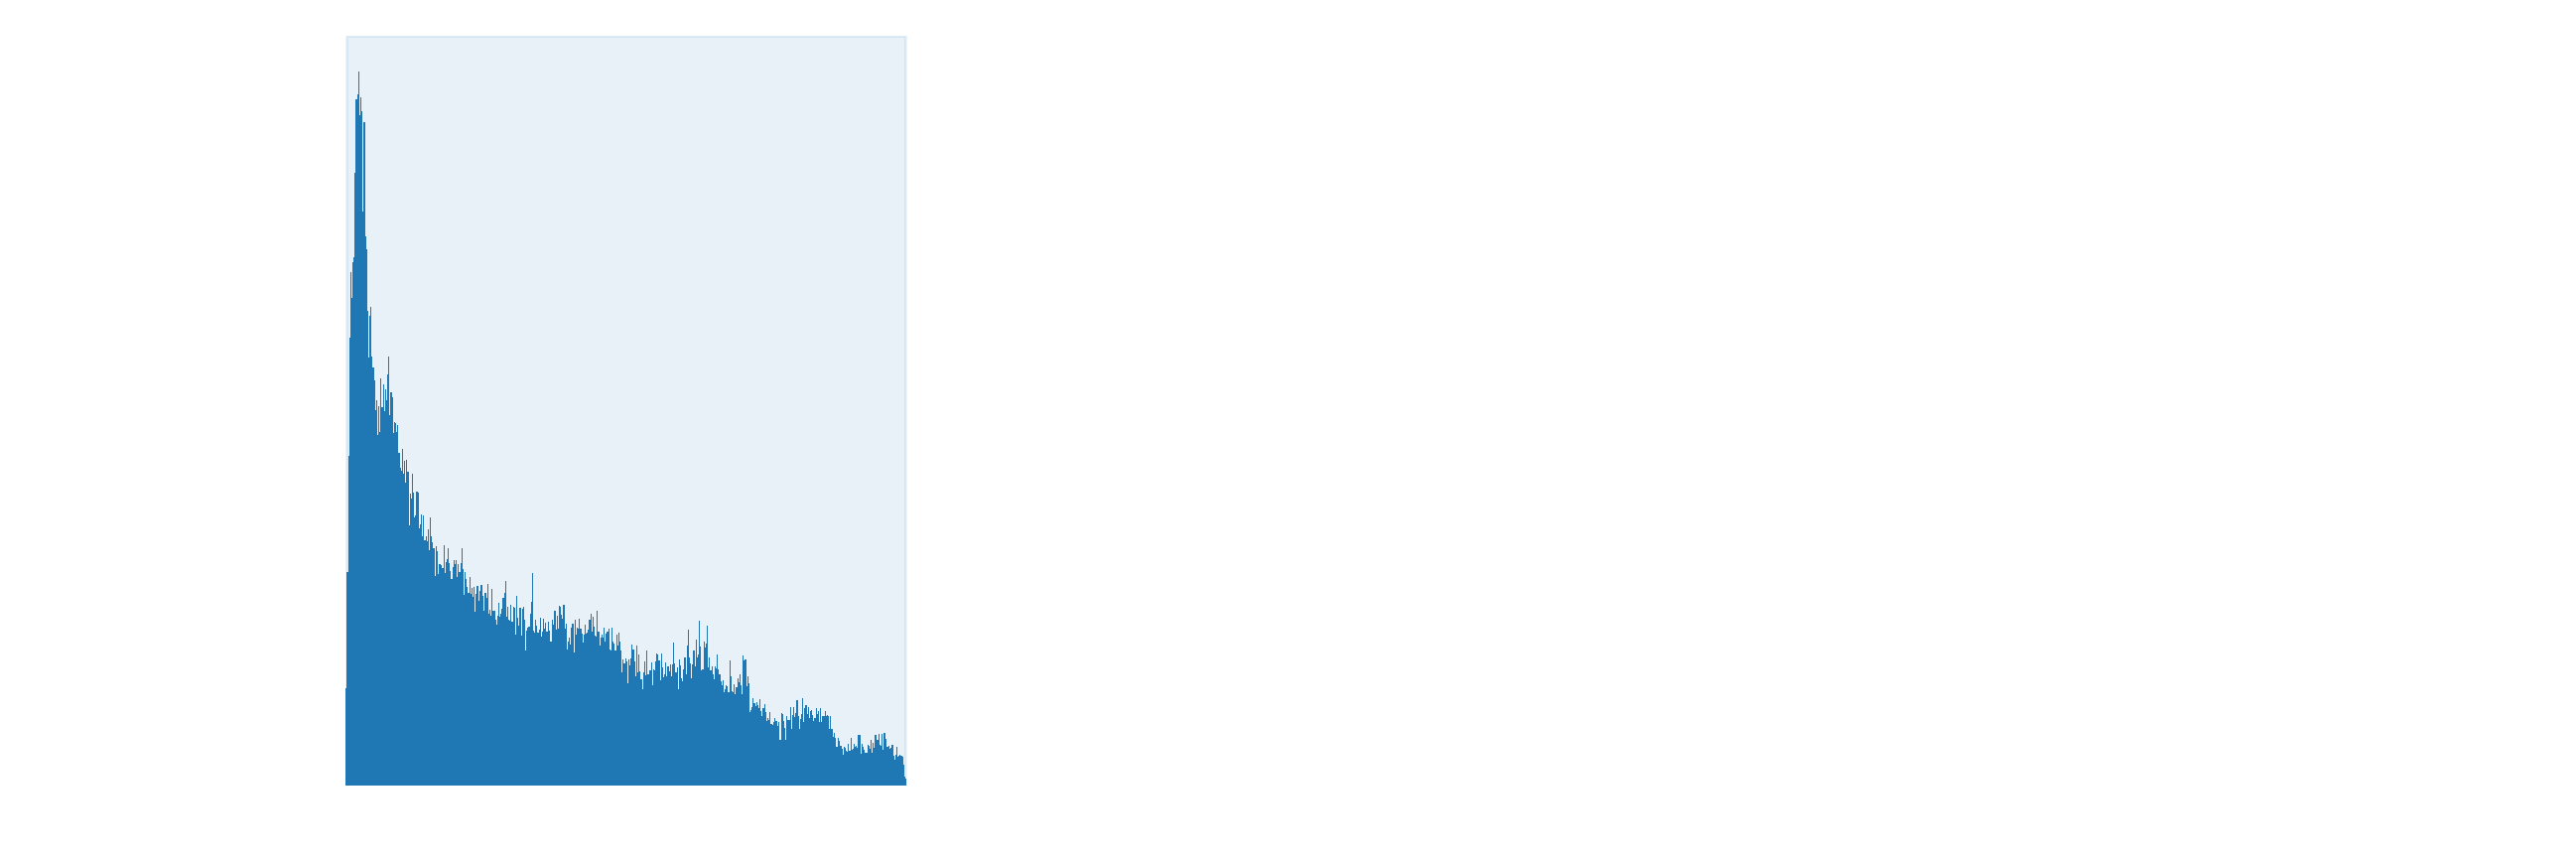

In [31]:
# Plot the distribution of intensities throughout the timeseries
fig, ax = plt.subplots(ntsamp // 2 + 1, 2, figsize=(16, 5))
ax = ax.flatten()
for n in range(ntsamp):
    ax[n].hist(img[n*npix:(n+1)*npix], bins=500, density=True);
    ax[n].axis('off')
    ax[n].set_xlim(-0.5, 1.5)
    ax[n].axvspan(0, 1, color="C0", alpha=0.1)
ax[-1].axis('off');

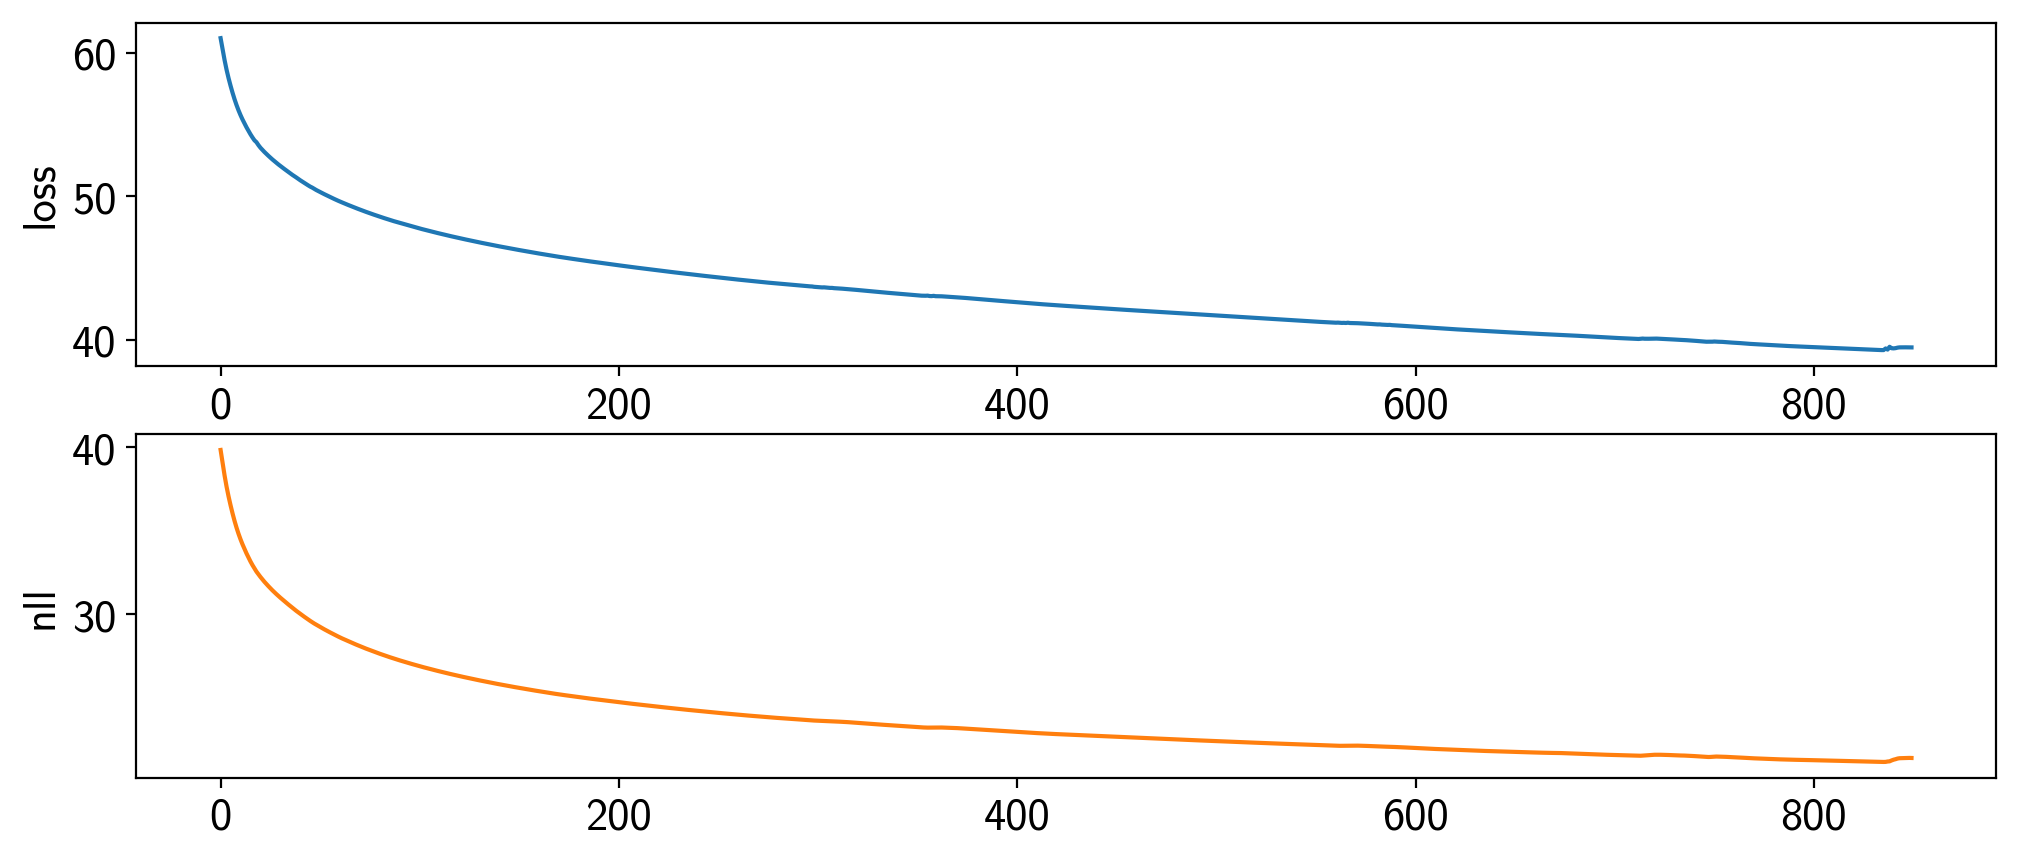

In [32]:
# Plot the loss and likelihood functions
fig, ax = plt.subplots(2, figsize=(12, 5))
burn = 0
ax[0].plot(loss[burn:] / (nc1 * nl1 + nc2 * nl2), alpha=0)
ax[1].plot(like[burn:] / (nc1 * nl1 + nc2 * nl2), alpha=0)
ax[0].set_ylim(*ax[0].get_ylim())
ax[1].set_ylim(*ax[1].get_ylim())
ax[0].plot(loss / (nc1 * nl1 + nc2 * nl2), color="C0");
ax[1].plot(like / (nc1 * nl1 + nc2 * nl2), color="C1");
ax[0].set_ylabel("loss")
ax[1].set_ylabel("nll");

In [33]:
# Set the map coefficients
map[1:, :] = wx

# Smooth it a little
earthshine.smooth(map, sigma=0.025)

# Render the image
res = 300
Z = map.render(res=res, projection="rect").reshape(res, res)

In [34]:
# Compute the visibility matrix
lon, lat, viz = earthshine.visibility(np.append(time1, time2), res=50)
lat_s = sorted(set(lat))
viz_lat_s = np.array([np.median(viz[lat == l]) for l in lat_s])
lat = np.linspace(-90, 90, res)
viz = np.interp(lat, lat_s, viz_lat_s).reshape(-1, 1)
viz /= np.max(viz)
Zviz = np.tile(viz, (1, res))

100%|██████████| 14382/14382 [00:03<00:00, 3659.74it/s]


In [35]:
# Load the "ground truth" image
if not os.path.exists("../data/viirs.npz"):
    %run ./VIIRS.ipynb
Ztru = np.load("../data/viirs.npz")["Ztru"]

# Figures!

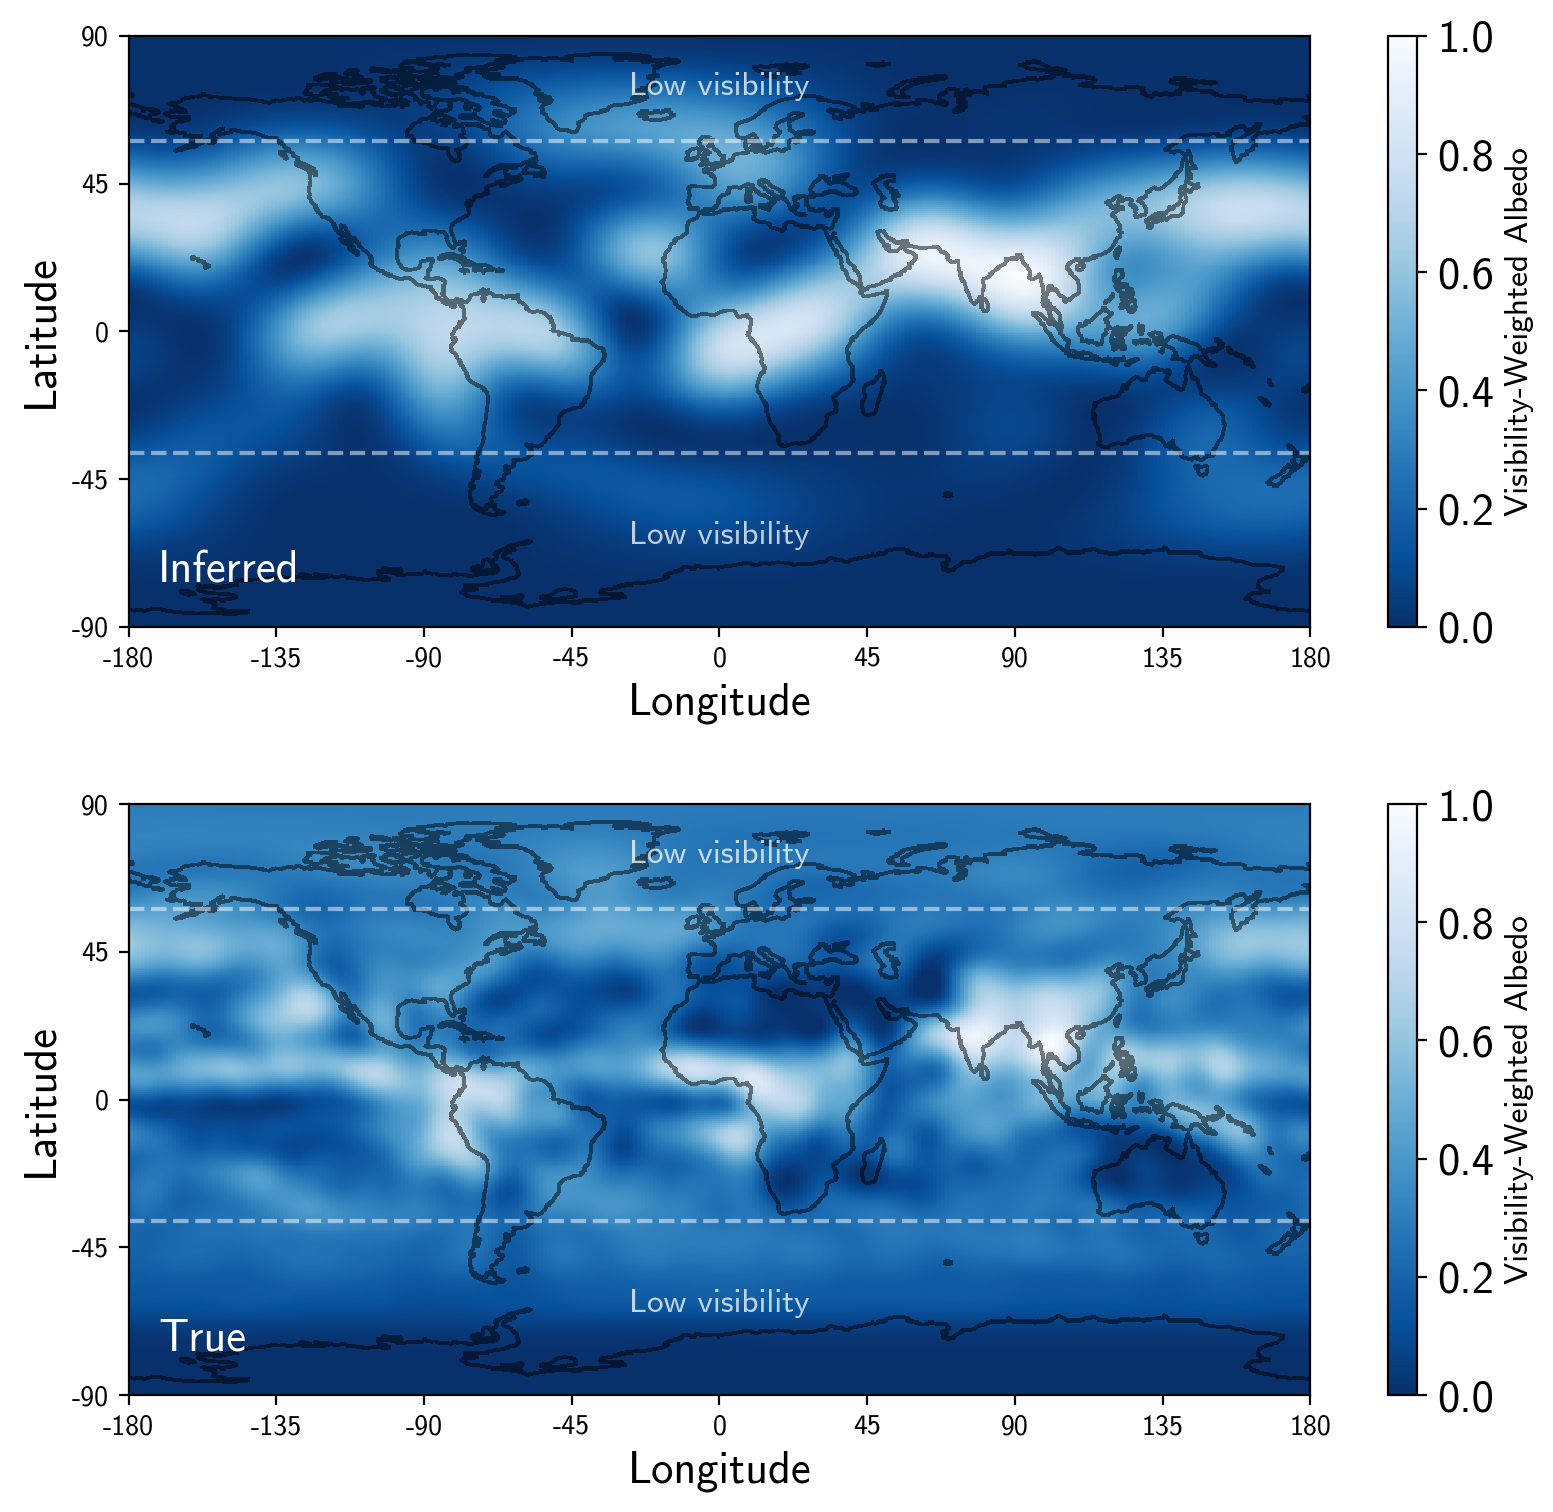

In [36]:
# Plot the results
fig, ax = plt.subplots(2, figsize=(10, 9))
fig.subplots_adjust(hspace=0.3)

# Plot the weighted solution
img = (Z * Zviz) / np.nanmax(Z * Zviz)
cmap.set_under(cmap(0))
im = ax[0].imshow(img, cmap=cmap, extent=(-180, 180, -90, 90), origin="lower", vmin=0, vmax=1);
cb = fig.colorbar(im, ax=ax[0]);
cb.set_label(label='Visibility-Weighted Albedo', fontsize=12)
ax[0].imshow(coastlines, extent=(-180, 180, -90, 90), alpha=0.5);
ax[0].axhline(lat[np.argmax(viz > 0.5)], color="w", ls='--', alpha=0.5)
ax[0].axhline(lat[::-1][np.argmax(viz[::-1] > 0.5)], color="w", ls='--', alpha=0.5);
ax[0].set_xlabel("Longitude")
ax[0].set_ylabel("Latitude")
ax[0].set_yticks([-90, -45, 0, 45, 90]);
ax[0].set_xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180]);
for tick in ax[0].xaxis.get_major_ticks() + ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
ax[0].annotate("Low visibility", xy=(0.5, 0.14), xycoords="axes fraction", color="w", ha="center", fontsize=12, alpha=0.75)
ax[0].annotate("Low visibility", xy=(0.5, 0.9), xycoords="axes fraction", color="w", ha="center", fontsize=12, alpha=0.75);

# Plot the weighted true image
img = (Ztru * Zviz) / np.nanmax(Ztru * Zviz)
im = ax[1].imshow(img, cmap=cmap, extent=(-180, 180, -90, 90), origin="lower", vmin=0, vmax=1);
cb = fig.colorbar(im, ax=ax[1]);
cb.set_label(label='Visibility-Weighted Albedo', fontsize=12)
ax[1].imshow(coastlines, extent=(-180, 180, -90, 90), alpha=0.5);
ax[1].axhline(lat[np.argmax(viz > 0.5)], color="w", ls='--', alpha=0.5)
ax[1].axhline(lat[::-1][np.argmax(viz[::-1] > 0.5)], color="w", ls='--', alpha=0.5);
ax[1].set_xlabel("Longitude")
ax[1].set_ylabel("Latitude")
ax[1].set_yticks([-90, -45, 0, 45, 90]);
ax[1].set_xticks([-180, -135, -90, -45, 0, 45, 90, 135, 180]);
for tick in ax[1].xaxis.get_major_ticks() + ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
ax[1].annotate("Low visibility", xy=(0.5, 0.14), xycoords="axes fraction", color="w", ha="center", fontsize=12, alpha=0.75)
ax[1].annotate("Low visibility", xy=(0.5, 0.9), xycoords="axes fraction", color="w", ha="center", fontsize=12, alpha=0.75);

ax[0].annotate("Inferred", xy=(0.025, 0.075), xycoords="axes fraction", color="w", ha="left", fontsize=16);
ax[1].annotate("True", xy=(0.025, 0.075), xycoords="axes fraction", color="w", ha="left", fontsize=16);

# Save
fig.savefig("../tex/figures/map.pdf", bbox_inches="tight")

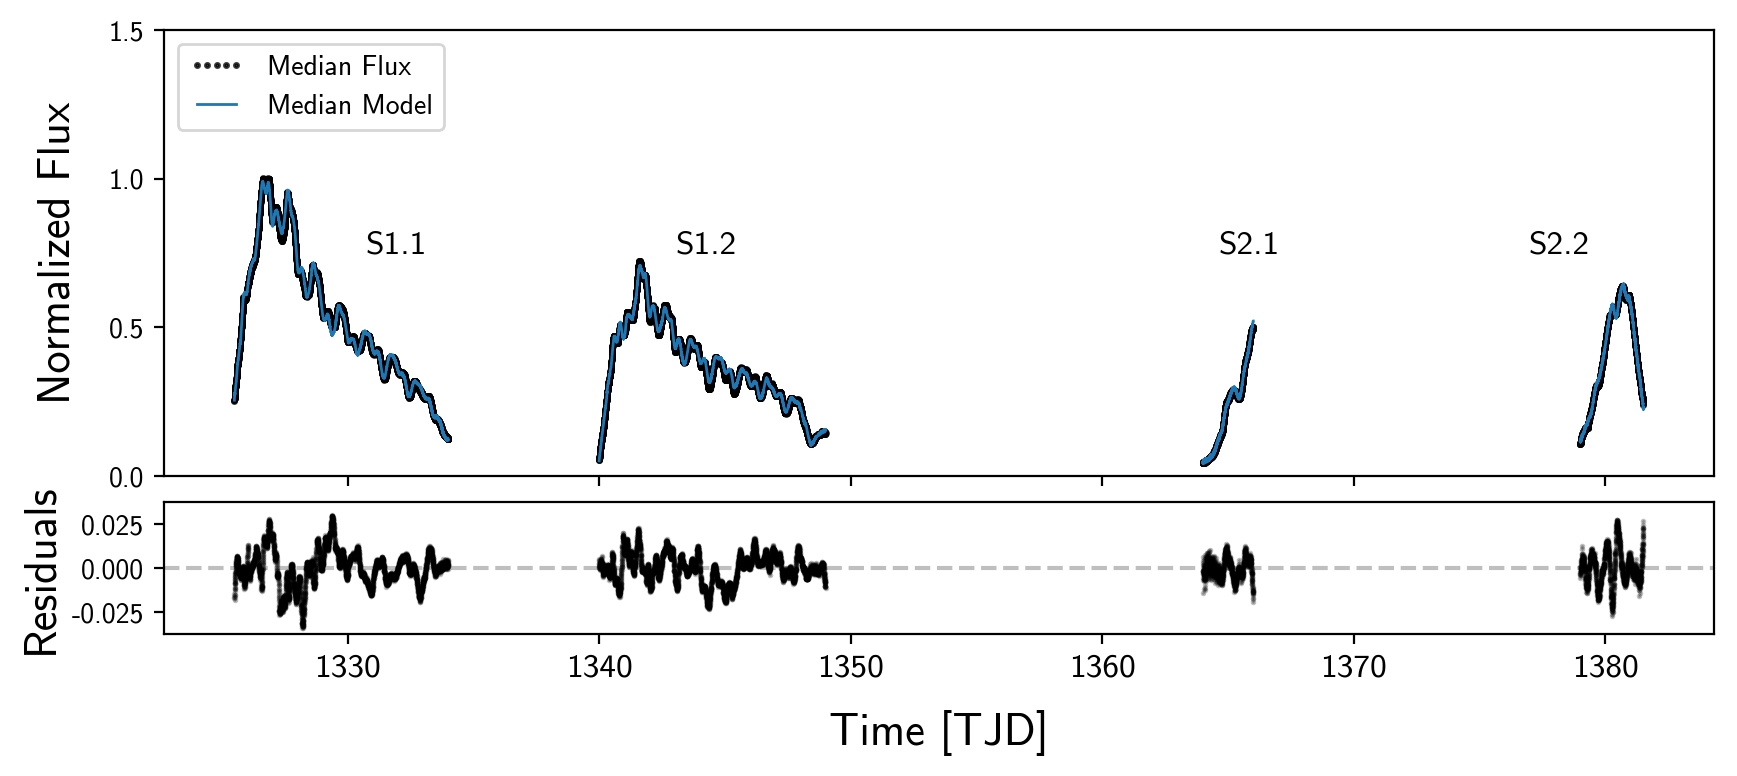

In [37]:
# Plot the data and model
fig = plt.figure(figsize=(10, 4))
ax = [plt.subplot2grid((4, 1), (0, 0), rowspan=3, colspan=1),
      plt.subplot2grid((4, 1), (3, 0), rowspan=1, colspan=1)]
t1 = np.array(time1)
t1[np.argmax(t1 > 1335)] = np.nan
t2 = np.array(time2)
t2[np.argmax(t2 > 1370)] = np.nan
ax[0].plot(time1, np.nanmedian([data1[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'k.', alpha=0.75, ms=3, label="Median Flux", zorder=-1)
ax[0].plot(t1, np.nanmedian([model1[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'C0-', lw=1, label="Median Model", zorder=-1)
ax[0].legend(fontsize=10, numpoints=5, loc="upper left")
ax[1].plot(time1, np.nanmedian([(data1 - model1)[slice(i * nc1, (i + 1) * nc1, 1)] 
                               for i in range(nl1)], axis=0), 'k.', alpha=0.25, ms=2, zorder=-1)
ax[0].plot(time2, np.nanmedian([data2[slice(i * nc2, (i + 1) * nc2, 1)] 
                               for i in range(nl2)], axis=0), 'k.', alpha=0.75, ms=3, zorder=-1)
ax[0].plot(t2, np.nanmedian([model2[slice(i * nc2, (i + 1) * nc2, 1)] 
                               for i in range(nl2)], axis=0), 'C0-', lw=1, zorder=-1)
ax[1].plot(time2, np.nanmedian([(data2 - model2)[slice(i * nc2, (i + 1) * nc2, 1)] 
                               for i in range(nl2)], axis=0), 'k.', alpha=0.25, ms=2, zorder=-1)
ax[0].set_ylabel("Normalized Flux", labelpad=11.0)
ax[1].set_ylabel("Residuals")
mx = max(np.abs(ax[1].get_ylim()))
ax[1].set_ylim(-mx, mx)
ax[0].set_xticklabels([])
ax[1].axhline(0, color="k", alpha=0.25, ls="--");
for tick in ax[1].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)

ax[0].set_yticks([0, 0.5, 1, 1.5])
ax[0].set_ylim(0, 1.5)
for tick in ax[0].yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax[1].xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
ax[1].set_xlabel("Time [TJD]", labelpad=10);

ax[0].annotate("S1.1", xy=(0.15, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax[0].annotate("S1.2", xy=(0.35, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax[0].annotate("S2.1", xy=(0.7, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax[0].annotate("S2.2", xy=(0.9, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax[0].set_rasterization_zorder(0)
ax[1].set_rasterization_zorder(0)

# Save
fig.savefig("../tex/figures/model.pdf", bbox_inches="tight", dpi=300)

Standard deviation of residuals: 0.009078


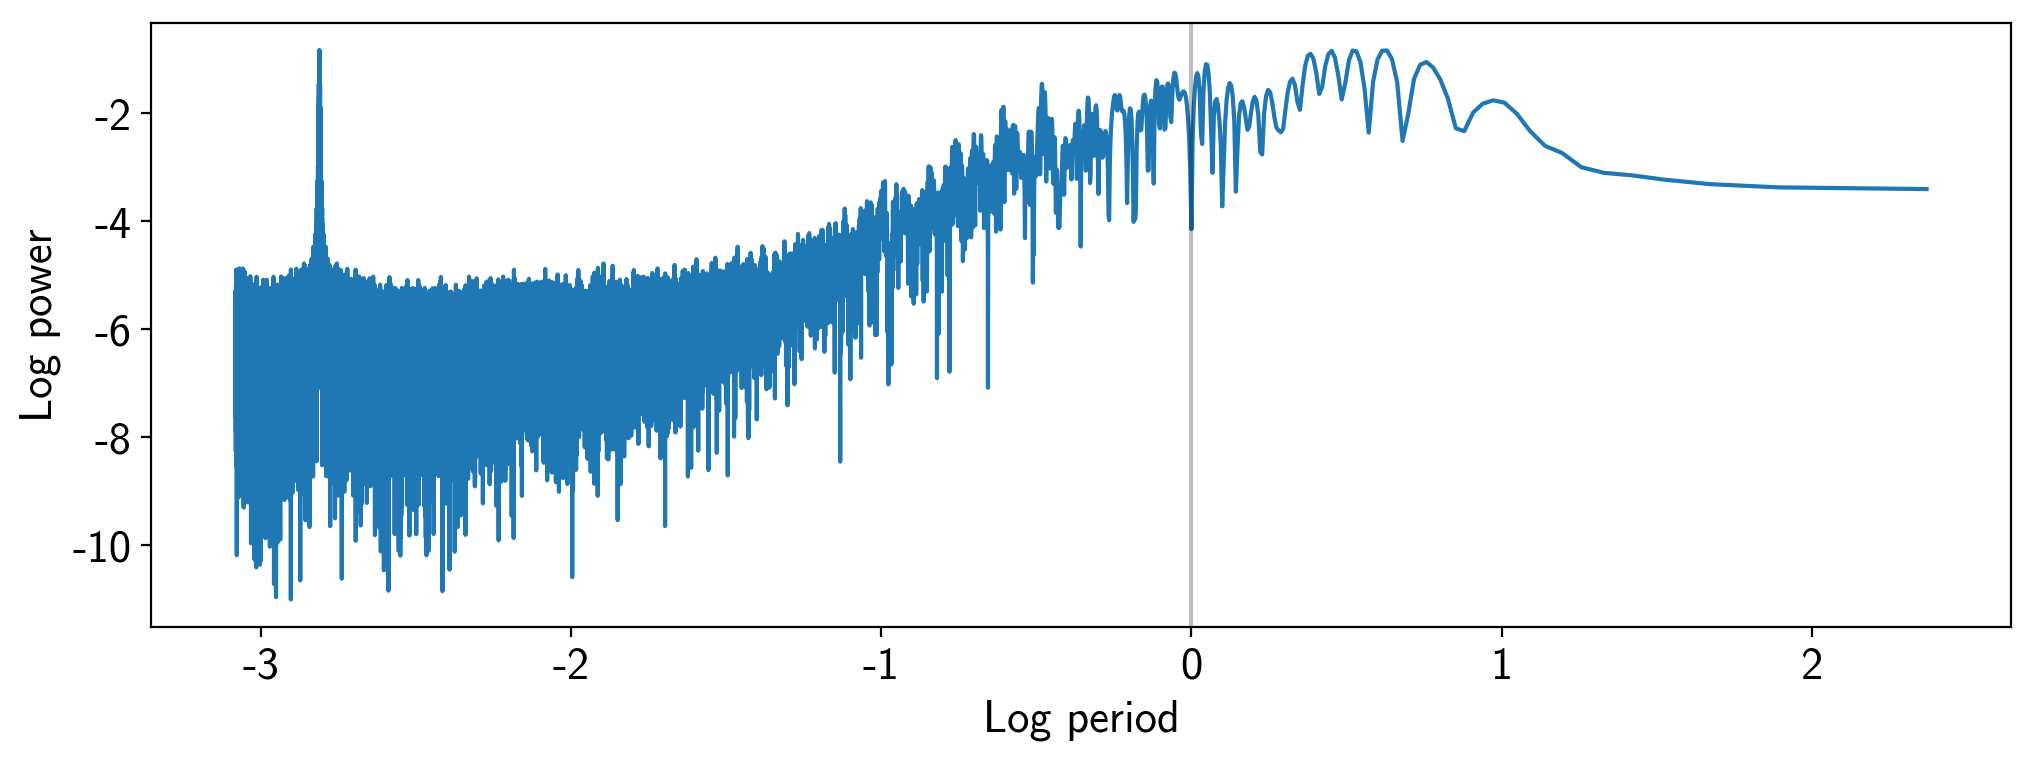

In [38]:
# Plot the power spectrum of the residuals
resid1 = np.nanmedian([(data1 - model1)[slice(i * nc1, (i + 1) * nc1, 1)] for i in range(nl1)], axis=0)
print("Standard deviation of residuals: %.6f" % np.std(resid1))
from astropy.stats import LombScargle
frequency, power = LombScargle(time1, resid1).autopower()
per = 1.0 / frequency
plt.plot(np.log10(per[:]), np.log10(power[:]));
plt.xlabel("Log period");
plt.axvline(0.0, color='k', alpha=0.25)
plt.ylabel("Log power");

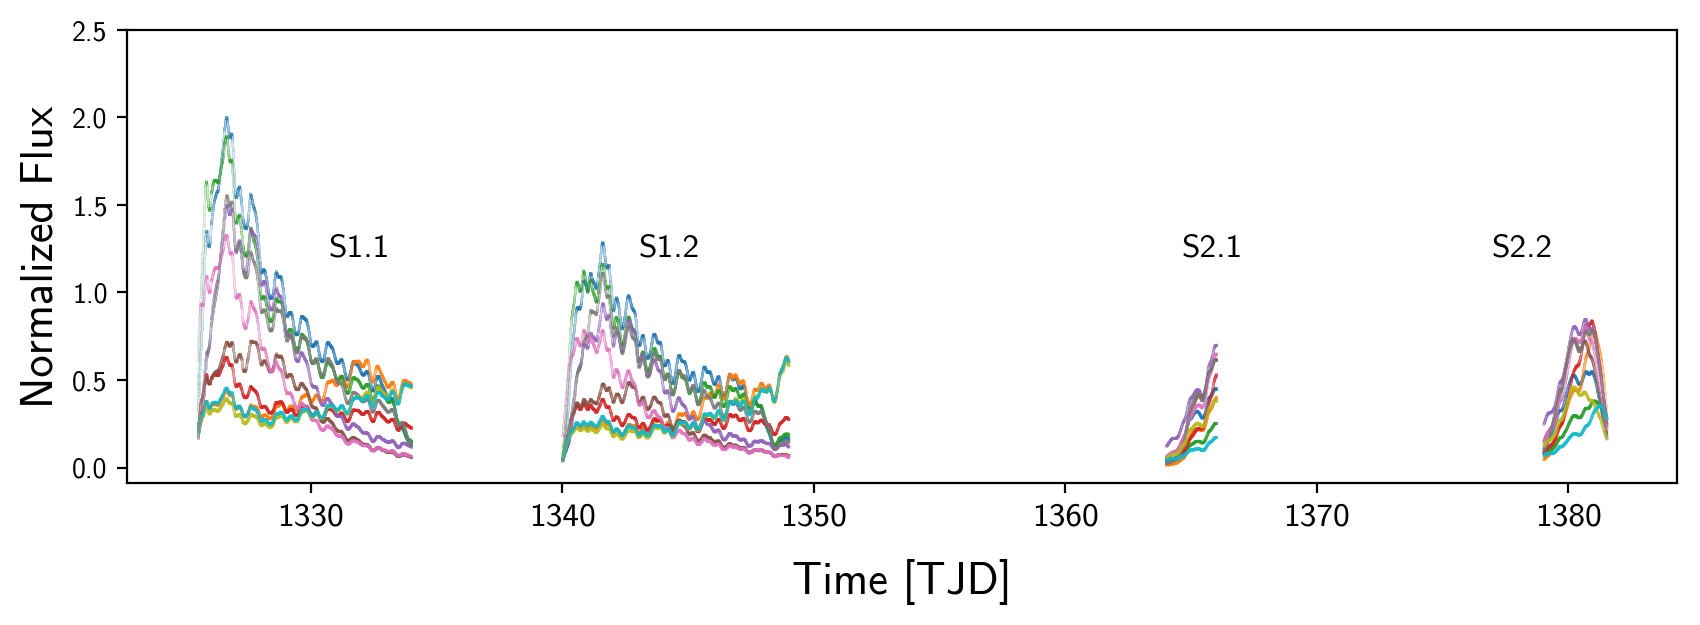

In [39]:
fig, ax = plt.subplots(1, figsize=(10, 3))
np.random.seed(42)
inds = np.random.choice(np.arange(len(flux1)), 10, replace=False)
for f in flux1[inds]:
    line, = ax.plot(time1, f, '.', ms=0.05, zorder=-1)
inds = np.random.choice(np.arange(len(flux2)), 10, replace=False)
for f in flux2[inds]:
    line, = ax.plot(time2, f, '.', ms=0.05, zorder=-1)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
ax.set_yticks([0, 0.5, 1, 1.5, 2, 2.5])
ax.set_ylabel("Normalized Flux")
ax.set_xlabel("Time [TJD]", labelpad=10);
ax.annotate("S1.1", xy=(0.15, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax.annotate("S1.2", xy=(0.35, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax.annotate("S2.1", xy=(0.7, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax.annotate("S2.2", xy=(0.9, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax.set_rasterization_zorder(0)

# Save
fig.savefig("../tex/figures/data.pdf", bbox_inches="tight", dpi=300)

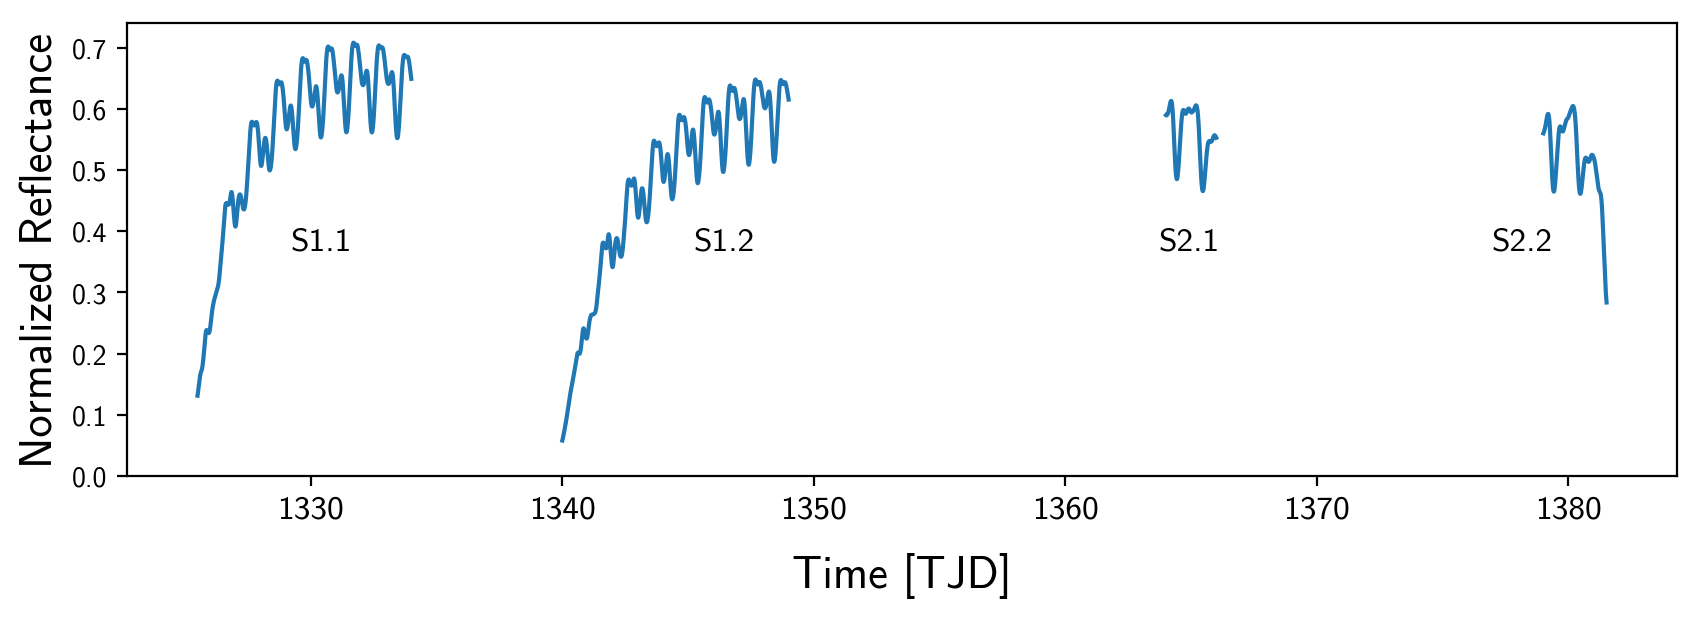

In [40]:
# Plot the starry model
fig, ax = plt.subplots(1, figsize=(10, 3))
ax.plot(t1, Xwx1, 'C0', zorder=-1)
ax.plot(t2, Xwx2, 'C0', zorder=-1);
ax.set_ylabel("Normalized Reflectance")
ax.set_xlabel("Time [TJD]", labelpad=10);
ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7])
for tick in ax.xaxis.get_major_ticks():
    tick.label.set_fontsize(12)
for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(10)
ax.annotate("S1.1", xy=(0.125, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax.annotate("S1.2", xy=(0.385, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax.annotate("S2.1", xy=(0.685, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax.annotate("S2.2", xy=(0.9, 0.5), xycoords="axes fraction", ha="center", fontsize=12, color="k");
ax.set_rasterization_zorder(0)

# Save
fig.savefig("../tex/figures/starry_model.pdf", bbox_inches="tight", dpi=300)